In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle

from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV

import shap

### Problem Statement Overview

the goal is to build a model to predict the outcome of a football match, given data for the past 9 years. All the football matches from 2009 to 2017 are covered in the dataset.

- this is a multiclass classification problem where target variable is FTR(full time result)
- We have to predict the FTR based on season performance and trends

**Data Dictonary**


| Name       | Description                                    |
|:-----------:|:-----------------------------------------------:|
| HomeTeam   | Home Team                                      |
| AwayTeam   | Away Team                                      |
| FTR        | Full-Time Result (H=Home Win, D=Draw, A=Away Win) |
| HTHG       | Half Time Home Team Goals                      |
| HTAG       | Half Time Away Team Goals                      |
| HS         | Home Team Shots                                |
| AS         | Away Team Shots                                |
| HST        | Home Team Shots on Target                      |
| AST        | Away Team Shots on Target                      |
| AC         | Away Team Corners                              |
| HF         | Home Team Fouls Committed                      |
| AF         | Away Team Fouls Committed                      |
| HC         | Home Team Corners                              |
| HY         | Home Team Yellow Cards                         |
| AY         | Away Team Yellow Cards                         |
| HR         | Home Team Red Cards                            |
| AR         | Away Team Red Cards                            |
| Date       | On which day the match was played              |
| league     | Under which league the match was played        |

**Assumptions**
- There is no data leak in train and test set
- All columns are in tests set are valid and will be available to us in real time

### Preprocessing

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test-3.csv')
test_data.drop(['index','Referee'],axis=1,inplace=True)
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d/%m/%y')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%d/%m/%y')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12789 entries, 0 to 12788
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   AC        12780 non-null  float64       
 1   AF        12778 non-null  float64       
 2   AR        12780 non-null  float64       
 3   AS        12780 non-null  float64       
 4   AST       12780 non-null  float64       
 5   AY        12780 non-null  float64       
 6   AwayTeam  12782 non-null  object        
 7   Date      12782 non-null  datetime64[ns]
 8   FTR       12782 non-null  object        
 9   HC        12780 non-null  float64       
 10  HF        12778 non-null  float64       
 11  HR        12780 non-null  float64       
 12  HS        12780 non-null  float64       
 13  HST       12780 non-null  float64       
 14  HTAG      12779 non-null  float64       
 15  HTHG      12779 non-null  float64       
 16  HY        12779 non-null  float64       
 17  HomeTeam  12

In [4]:
# Checking Nan values
train_data.isna().mean()

AC          0.000704
AF          0.000860
AR          0.000704
AS          0.000704
AST         0.000704
AY          0.000704
AwayTeam    0.000547
Date        0.000547
FTR         0.000547
HC          0.000704
HF          0.000860
HR          0.000704
HS          0.000704
HST         0.000704
HTAG        0.000782
HTHG        0.000782
HY          0.000782
HomeTeam    0.000547
league      0.000000
dtype: float64

In [5]:
#dropping values where FTR is nan
train_data=train_data[~train_data.FTR.isna()]
#dropping the rest if 80% of data is empty
train_data.dropna(thresh=len(train_data.columns) * 0.8, inplace=True)

In [6]:
train_data[train_data.AF.isna()]

AC  AF   AR   AS  AST   AY   AwayTeam       Date FTR   HC  HF   HR  \
5620  5.0 NaN  0.0  6.0  3.0  3.0  Marseille 2011-09-18   H  3.0 NaN  0.0   
5733  1.0 NaN  0.0  9.0  3.0  5.0      Nancy 2011-12-17   A  8.0 NaN  0.0   

        HS  HST  HTAG  HTHG   HY HomeTeam   league  
5620  10.0  5.0   0.0   2.0  0.0     Lyon  ligue-1  
5733   9.0  1.0   1.0   0.0  2.0     Caen  ligue-1

In [7]:
#filling rest of the data
train_data.fillna(0,inplace=True)

The season starts in August end in May for all the leagues.So we would require training data from Ausgust onwards

In [8]:
train_data = train_data[train_data.Date>='2009-08-01']

Inspecting the teams

In [9]:
set(train_data.AwayTeam.unique().tolist())

{'Ajaccio',
 'Ajaccio GFCO',
 'Alaves',
 'Almeria',
 'Angers',
 'Arles',
 'Arsenal',
 'Aston Villa',
 'Atalanta',
 'Ath Bilbao',
 'Ath Madrid',
 'Augsburg',
 'Auxerre',
 'Barcelona',
 'Bari',
 'Bastia',
 'Bayern Munich',
 'Betis',
 'Birmingham',
 'Blackburn',
 'Blackpool',
 'Bochum',
 'Bologna',
 'Bolton',
 'Bordeaux',
 'Boulogne',
 'Bournemouth',
 'Brescia',
 'Brest',
 'Burnley',
 'Caen',
 'Cagliari',
 'Carpi',
 'Catania',
 'Celta',
 'Cesena',
 'Chelsea',
 'Chievo',
 'Cordoba',
 'Crotone',
 'Crystal Palace',
 'Darmstadt',
 'Dijon',
 'Dortmund',
 'Eibar',
 'Ein Frankfurt',
 'Elche',
 'Empoli',
 'Espanol',
 'Everton',
 'Evian Thonon Gaillard',
 'FC Koln',
 'Fiorentina',
 'Fortuna Dusseldorf',
 'Freiburg',
 'Frosinone',
 'Fulham',
 'Genoa',
 'Getafe',
 'Granada',
 'Grenoble',
 'Greuther Furth',
 'Guingamp',
 'Hamburg',
 'Hannover',
 'Hercules',
 'Hertha',
 'Hoffenheim',
 'Hull',
 'Ingolstadt',
 'Inter',
 'Juventus',
 'Kaiserslautern',
 'La Coruna',
 'Las Palmas',
 'Lazio',
 'Le Mans',
 '

In [10]:
set(train_data.HomeTeam.unique().tolist())

{'Ajaccio',
 'Ajaccio GFCO',
 'Alaves',
 'Almeria',
 'Angers',
 'Arles',
 'Arsenal',
 'Aston Villa',
 'Atalanta',
 'Ath Bilbao',
 'Ath Madrid',
 'Augsburg',
 'Auxerre',
 'Barcelona',
 'Bari',
 'Bastia',
 'Bayern Munich',
 'Betis',
 'Birmingham',
 'Blackburn',
 'Blackpool',
 'Bochum',
 'Bologna',
 'Bolton',
 'Bordeaux',
 'Boulogne',
 'Bournemouth',
 'Brescia',
 'Brest',
 'Burnley',
 'Caen',
 'Cagliari',
 'Carpi',
 'Catania',
 'Celta',
 'Cesena',
 'Chelsea',
 'Chievo',
 'Cordoba',
 'Crotone',
 'Crystal Palace',
 'Darmstadt',
 'Dijon',
 'Dortmund',
 'Eibar',
 'Ein Frankfurt',
 'Elche',
 'Empoli',
 'Espanol',
 'Everton',
 'Evian Thonon Gaillard',
 'FC Koln',
 'Fiorentina',
 'Fortuna Dusseldorf',
 'Freiburg',
 'Frosinone',
 'Fulham',
 'Genoa',
 'Getafe',
 'Granada',
 'Grenoble',
 'Greuther Furth',
 'Guingamp',
 'Hamburg',
 'Hannover',
 'Hercules',
 'Hertha',
 'Hoffenheim',
 'Hull',
 'Ingolstadt',
 'Inter',
 'Juventus',
 'Kaiserslautern',
 'La Coruna',
 'Las Palmas',
 'Lazio',
 'Le Mans',
 '

we have around 159 teams in total and there seem to be some incosistent naming conventions.

For example:
-  "Ajaccio" and "Ajaccio GFCO" are the same
- "Ath Bilbao" and "Athletic Bilbao" are the same


In [11]:
#checking if home teams are a subset of away teams
set(train_data['AwayTeam'].unique()).issubset(set(train_data['HomeTeam'].unique()))

True

In [12]:
#checking if home teams in test data are a subset of home teams train data
set(test_data['HomeTeam'].unique()).issubset(set(train_data['HomeTeam'].unique()))

False

some teams might have relegated in 2017-18 season

let's normalise the team names.

In [13]:
team_name_mapping = {
    'Ajaccio GFCO': 'Ajaccio',
    'Atletico': 'Atletico Madrid',
    'Betis': 'Real Betis',
    'Celta': 'Celta Vigo',
    'Dep La Coruna': 'Deportivo La Coruna',
    'Eibar': 'SD Eibar',
    'Frosinone': 'Frosinone Calcio',
    'Gijon': 'Sporting Gijon',
    'Huesca': 'SD Huesca',
    'Inter': 'Inter Milan',
    'Leganes': 'CD Leganes',
    'Malaga': 'Malaga CF',
    'Osasuna': 'CA Osasuna',
    'Palermo': 'US Palermo',
    'SPAL': 'Spal',
    'Sevilla FC': 'Sevilla',
    'Verona': 'Hellas Verona',
    'Wolverhampton': 'Wolves'
}

# Apply the mapping to HomeTeam and AwayTeam columns
train_data['HomeTeam'] = train_data['HomeTeam'].replace(team_name_mapping)
train_data['AwayTeam'] = train_data['AwayTeam'].replace(team_name_mapping)

let's add a season column to our data to represent the official season

In [14]:
# Add a season column based on the official season (August to May)
train_data['season'] = train_data['Date'].apply(lambda date: f'{date.year}-{date.year + 1}' if date.month >= 8 else f'{date.year - 1}-{date.year}')
test_data['season'] = test_data['Date'].apply(lambda date: f'{date.year}-{date.year + 1}' if date.month >= 8 else f'{date.year - 1}-{date.year}')

Verifying the same 

In [15]:
# Calculate the number of matches played by each team in each season (league-wise)
matches_per_team_season_league = train_data.groupby(['league', 'season', 'HomeTeam']).size() + train_data.groupby(['league', 'season', 'AwayTeam']).size()
matches_per_team_season_league = matches_per_team_season_league.reset_index(name='Matches')

In [16]:
set(matches_per_team_season_league.Matches)

{34, 37, 38}

In [17]:
set(matches_per_team_season_league.groupby(['league', 'season']).HomeTeam.nunique())

{18, 20}

Matches and team seem consistent with the leagues .only in some cases where we dropped the mathces we would have 37 matches

### EDA

For our EDA, we will follow the following steps

1. **Basic Overview**
2. **Match Outcomes Distribution**
3. **Home vs. Away Performance**
4. **League-wise Analysis**
5. **Seasonal Trends**
6. **Key Match Statistics**
7. **Disciplinary Actions**

#### Basic Overview

In [18]:
train_data.describe()

AC            AF            AR            AS           AST  \
count  12780.000000  12780.000000  12780.000000  12780.000000  12780.000000   
mean       4.497966     14.409546      0.140063     11.234898      4.177465   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000     11.000000      0.000000      8.000000      2.000000   
50%        4.000000     14.000000      0.000000     11.000000      4.000000   
75%        6.000000     17.000000      0.000000     14.000000      6.000000   
max       19.000000     34.000000      3.000000     39.000000     20.000000   
std        2.582074      4.671881      0.377728      4.526805      2.497475   

                 AY                           Date            HC  \
count  12780.000000                          12780  12780.000000   
mean       2.173552  2013-06-12 03:19:53.239436544      5.791080   
min        0.000000            2009-08-07 00:00:00      0.000000   
25%        1.000000            2011-03-19 00:00:00      4.000000   
50%        2.000000            2013-01-06 00:00:00      5.000000   
75%        3.000000            2015-10-24 00:00:00      8.000000   
max        9.000000            2017-05-28 00:00:00     21.000000   
std        1.367718                            NaN      3.012718   

                 HF            HR            HS           HST          HTAG  \
count  12780.000000  12780.000000  12780.000000  12780.000000  12780.000000   
mean      13.914945      0.101252     14.061033      5.268545      0.494757   
min        0.000000      0.000000      1.000000      0.000000      0.000000   
25%       11.000000      0.000000     10.000000      3.000000      0.000000   
50%       14.000000      0.000000     14.000000      5.000000      0.000000   
75%       17.000000      0.000000     17.000000      7.000000      1.000000   
max       38.000000      3.000000     43.000000     24.000000      5.000000   
std        4.575411      0.320539      5.170604      2.872875      0.713889   

               HTHG            HY  
count  12780.000000  12780.000000  
mean       0.691080      1.862285  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        0.000000      2.000000  
75%        1.000000      3.000000  
max        5.000000      8.000000  
std        0.833149      1.313269

##### Key insights
- **Goal Distribution**: The distribution of goals is skewed towards lower values, indicating that high-scoring games are less common.
- **Shots Distribution**: The number of shots and shots on target also follows a similar trend, with most teams having fewer shots per game, suggesting that efficient scoring opportunities are crucial.
- **Disciplinary Actions**: The distribution of yellow and red cards shows that most games have few disciplinary actions, which is typical for competitive but controlled gameplay.

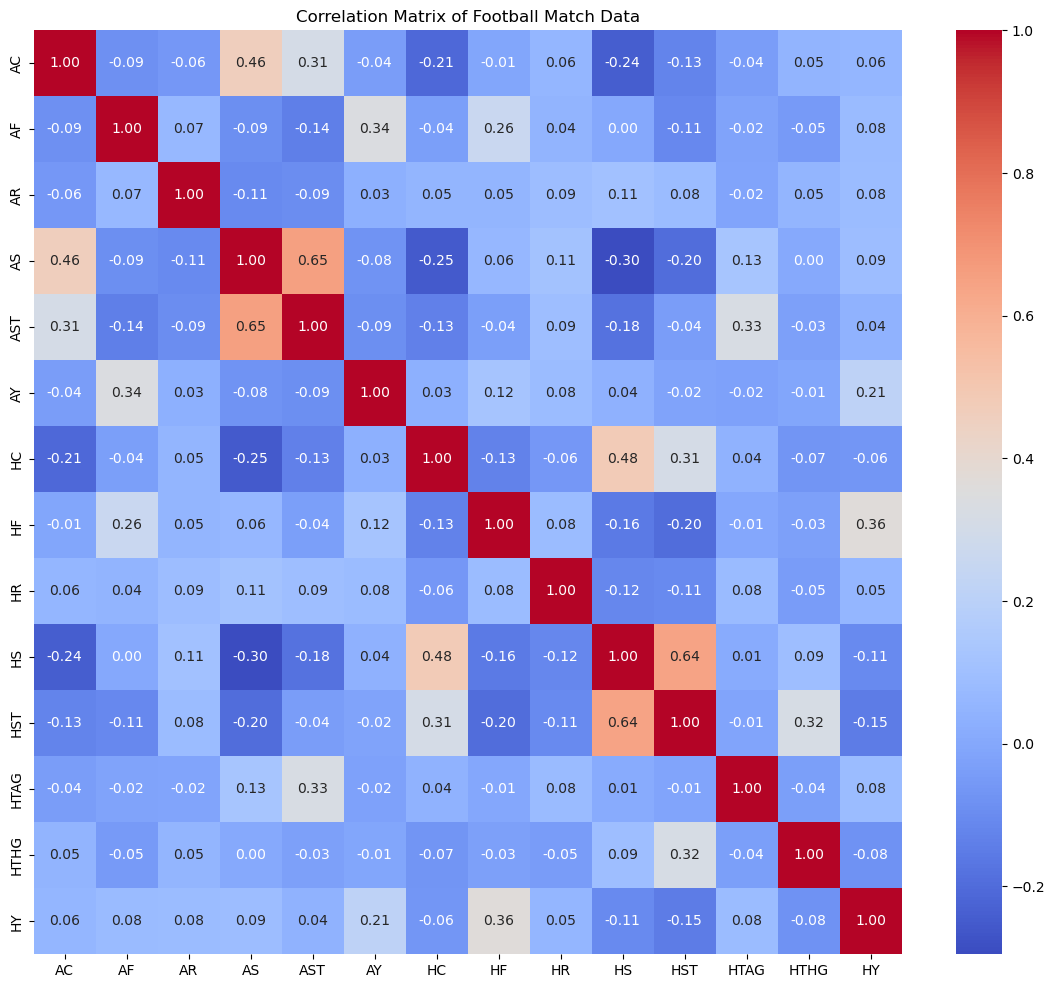

In [19]:
# Correlation analysis
correlation_matrix = train_data.select_dtypes(['int','float']).corr()

# Plotting the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Football Match Data")
plt.show()


In [20]:
print("\nKey Insights from Correlation Analysis:")
print("- Strong positive correlation between Home Team Shots (HS) and Home Team Shots on Target (HST):", correlation_matrix.loc['HS', 'HST'])
print("- Strong positive correlation between Away Team Shots (AS) and Away Team Shots on Target (AST):", correlation_matrix.loc['AS', 'AST'])
print("- Moderate positive correlation between Home Team Shots on Target (HST) and Half-Time Home Team Goals (HTHG):", correlation_matrix.loc['HST', 'HTHG'])
print("- Moderate positive correlation between Home Team Fouls (HF) and Home Team Yellow Cards (HY):", correlation_matrix.loc['HF', 'HY'])
print("- Moderate negative correlation between Home Team Corners (HC) and Home Team Shots on Target (HST):", correlation_matrix.loc['HC', 'HST'])
print("- Moderate negative correlation between Home Team Shots (HS) and Away Team Corners (AC):", correlation_matrix.loc['HS', 'AC'])



Key Insights from Correlation Analysis:
- Strong positive correlation between Home Team Shots (HS) and Home Team Shots on Target (HST): 0.6445152969707032
- Strong positive correlation between Away Team Shots (AS) and Away Team Shots on Target (AST): 0.6543129761733167
- Moderate positive correlation between Home Team Shots on Target (HST) and Half-Time Home Team Goals (HTHG): 0.3175932607324304
- Moderate positive correlation between Home Team Fouls (HF) and Home Team Yellow Cards (HY): 0.3642381998190345
- Moderate negative correlation between Home Team Corners (HC) and Home Team Shots on Target (HST): 0.3077186781380581
- Moderate negative correlation between Home Team Shots (HS) and Away Team Corners (AC): -0.24389068978291634


##### Key insights

- Teams that have a higher number of shots on target are likely to score more goals, especially by half-time. This highlights the importance of offensive efficiency(ie- players usually get less offensive as time progresses).
- The correlation between fouls and yellow cards suggests the need for disciplined defensive play to avoid penalties that can affect game outcomes.
- The relationship between shots and corners suggests that aggressive offensive strategies often lead to more corner opportunities. 

#### Distributions of the Outcome

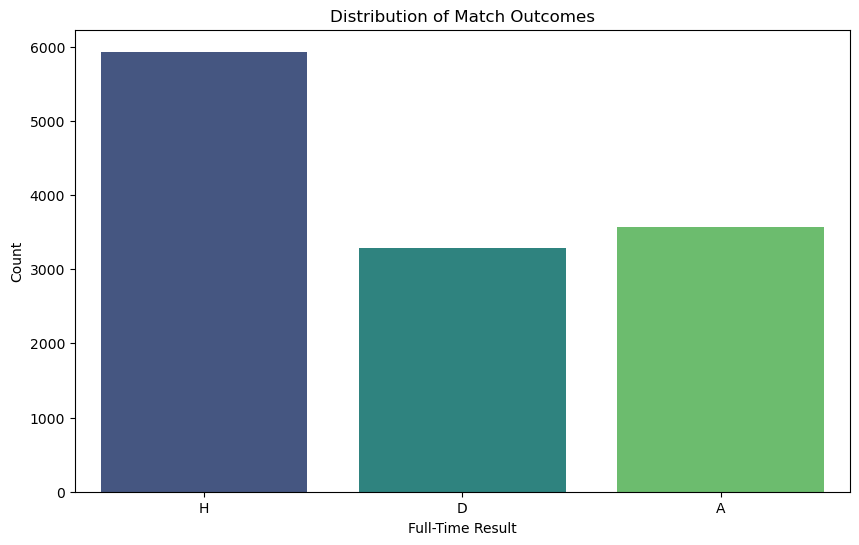

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='FTR', data=train_data, palette='viridis')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Full-Time Result')
plt.ylabel('Count')
plt.show()

In [22]:
train_data.FTR.value_counts()

FTR
H    5931
A    3566
D    3283
Name: count, dtype: int64

##### Key insights

The distribution of match outcomes over the past 9 years shows a definative edge for home wins over away wins, with draws being less frequent. This indicates a home advantage, which is common for football matches.

let's also visualise data over different *Season's*

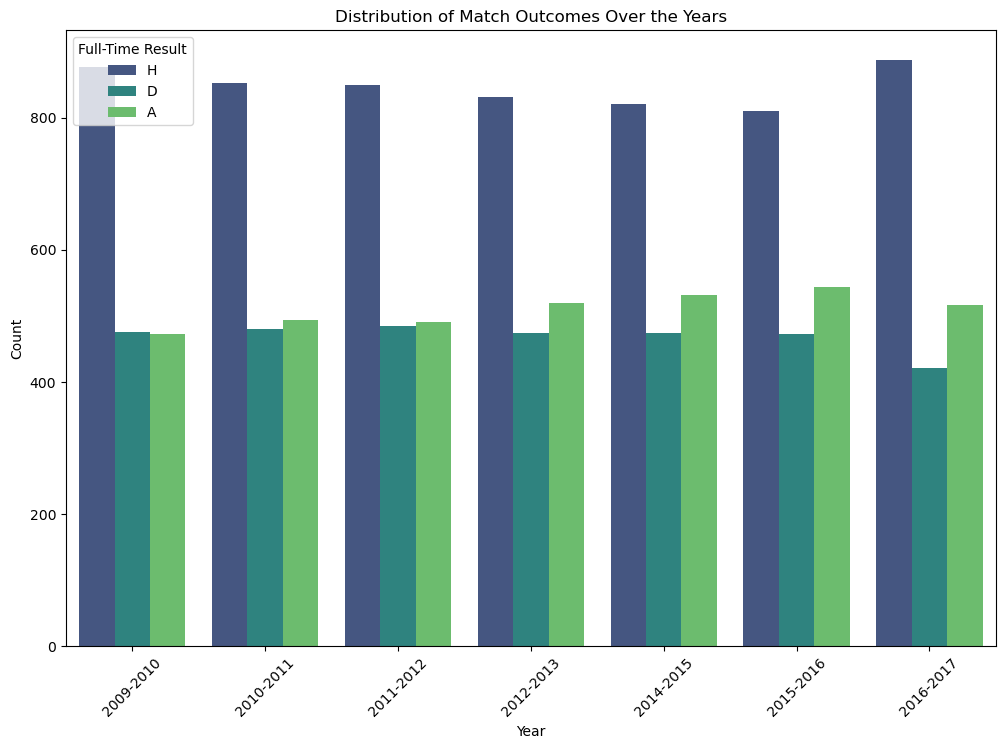

In [23]:
# distribution of match outcomes over the years
plt.figure(figsize=(12, 8))
sns.countplot(x=train_data['season'], hue='FTR', data=train_data, palette='viridis')
plt.title('Distribution of Match Outcomes Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Full-Time Result', loc='upper left')
plt.xticks(rotation=45)
plt.show()

##### Key insights

- The number of matches per year seems to vary, with certain years having more recorded matches than others.
- In general, home wins (H) consistently appear to be the most frequent outcome across all years

#### Home vs. Away Performance

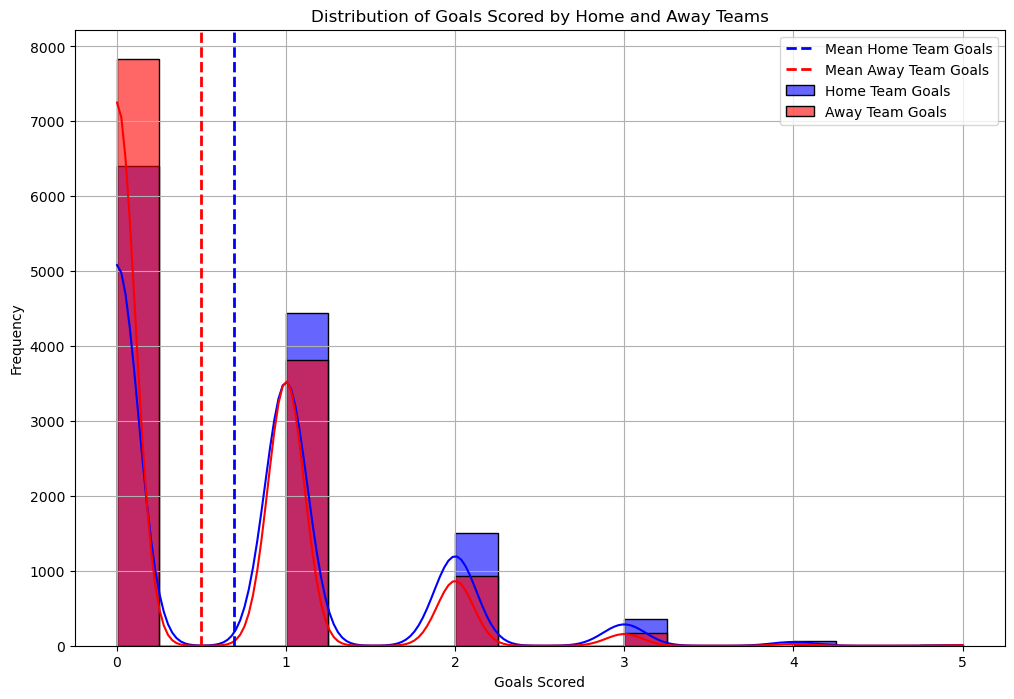

In [24]:
# Goals scored by home and away teams
plt.figure(figsize=(12, 8))
sns.histplot(train_data['HTHG'], bins=20, kde=True, color='blue', label='Home Team Goals', alpha=0.6)
sns.histplot(train_data['HTAG'], bins=20, kde=True, color='red', label='Away Team Goals', alpha=0.6)

plt.axvline(train_data['HTHG'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Mean Home Team Goals')
plt.axvline(train_data['HTAG'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean Away Team Goals')

plt.title('Distribution of Goals Scored by Home and Away Teams')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

##### Key insights

- **Home Team Goals (HTHG)**: The distribution shows that home teams tend to score a modest number of goals in most matches, with a peak at lower goal counts. The distribution has a long tail, indicating that high goal counts by home teams are less frequent but do occur.
- **Away Team Goals (HTAG)**: Similarly, away teams also show a peak at lower goal counts. However, the frequency of higher goal counts is even less compared to home teams, suggesting that away teams generally score fewer goals on average.
- Goals scored by home teams are generally higher than those scored by away teams, indicating a potential home advantage.

#### Seasonal Trends

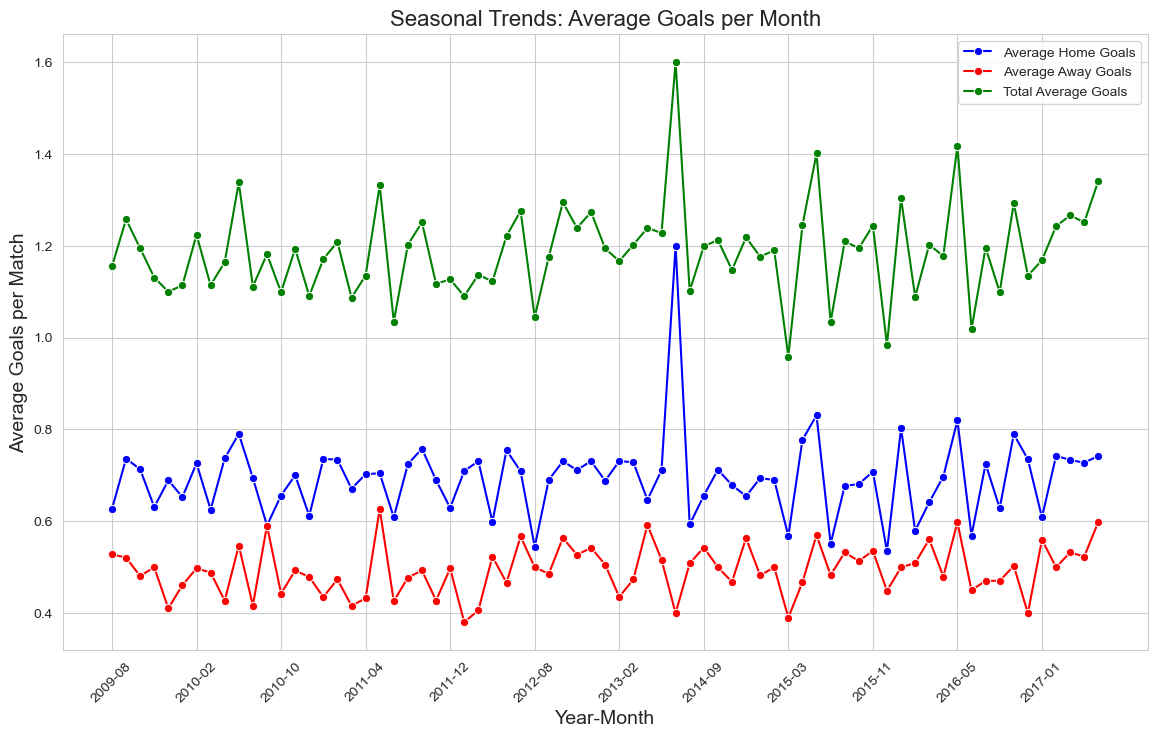

In [25]:
# Aggregate data by year and month
monthly_goals = train_data.copy(deep=True)
monthly_goals['YearMonth'] = monthly_goals['Date'].dt.to_period('M')

# Average goals per month
monthly_goals = monthly_goals.groupby('YearMonth').agg({'HTHG': 'mean', 'HTAG': 'mean'}).reset_index()
monthly_goals['TotalGoals'] = monthly_goals['HTHG'] + monthly_goals['HTAG']

# Convert 'YearMonth' to string for proper handling in plots
monthly_goals['YearMonth'] = monthly_goals['YearMonth'].astype(str)

# Set the plot style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(14, 8))

# Plotting the average home and away goals per month
sns.lineplot(x='YearMonth', y='HTHG', data=monthly_goals, marker='o', label='Average Home Goals', color='blue')
sns.lineplot(x='YearMonth', y='HTAG', data=monthly_goals, marker='o', label='Average Away Goals', color='red')

# Plotting the total average goals per month
sns.lineplot(x='YearMonth', y='TotalGoals', data=monthly_goals, marker='o', label='Total Average Goals', color='green')

# Adding title and labels
plt.title('Seasonal Trends: Average Goals per Month', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Average Goals per Match', fontsize=14)

# Reducing the number of x-axis labels for better readability
plt.xticks(ticks=range(0, len(monthly_goals), 6), labels=monthly_goals['YearMonth'][::6], rotation=45)

# Adding legend
plt.legend()

# Display the plot
plt.show()

##### Key insights

- **The average goals scored per match** fluctuate over the months, indicating potential seasonal effects. Factors like player fatigue, weather conditions, and fixture congestion might contribute to these trends.

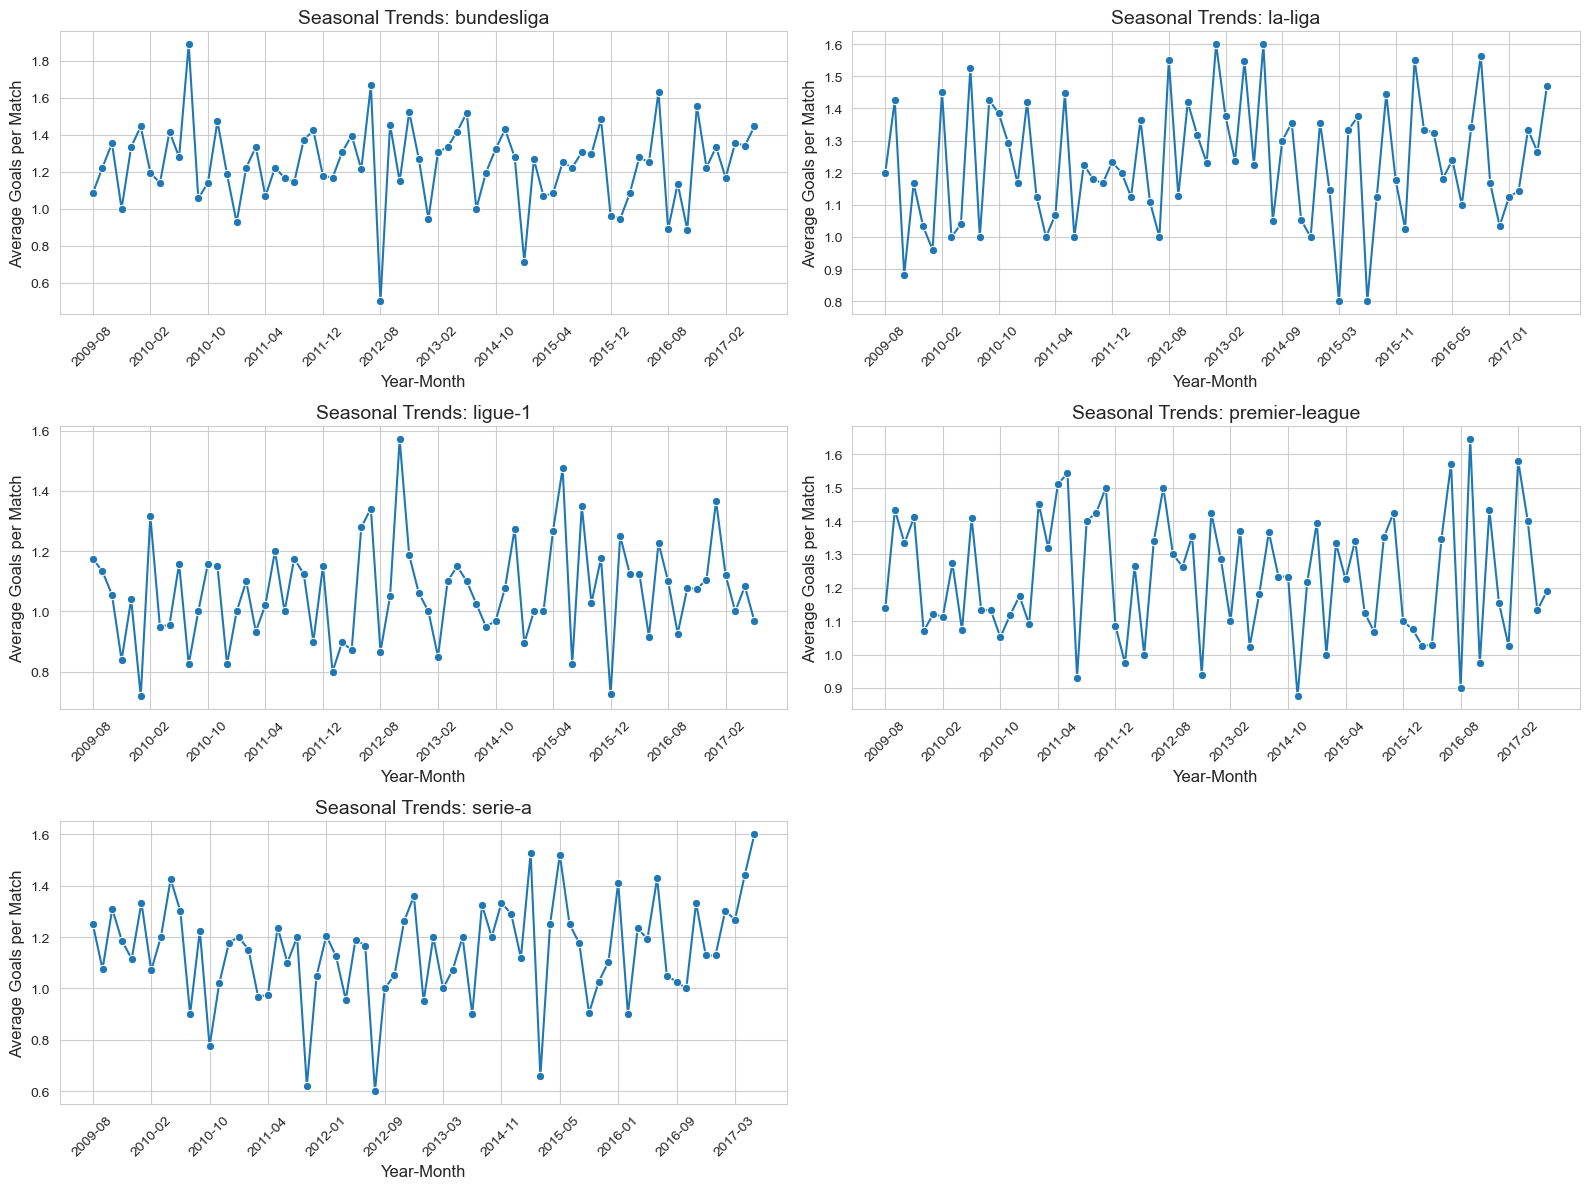

In [26]:
# Aggregate data by year, month, and league
monthly_goals_league = train_data.copy(deep=True)
monthly_goals_league['YearMonth'] = monthly_goals_league['Date'].dt.to_period('M')

# Average goals per month per league
monthly_goals_league = monthly_goals_league.groupby(['YearMonth', 'league']).agg({'HTHG': 'mean', 'HTAG': 'mean'}).reset_index()
monthly_goals_league['TotalGoals'] = monthly_goals_league['HTHG'] + monthly_goals_league['HTAG']

# Convert 'YearMonth' to string for proper handling in plots
monthly_goals_league['YearMonth'] = monthly_goals_league['YearMonth'].astype(str)

leagues = monthly_goals_league['league'].unique()
n_leagues = len(leagues)

# Define the number of rows and columns for subplots
n_rows = (n_leagues // 2) + (n_leagues % 2)
n_cols = 2

plt.figure(figsize=(16, 4 * n_rows))

for i, league in enumerate(leagues):
    plt.subplot(n_rows, n_cols, i + 1)
    league_data = monthly_goals_league[monthly_goals_league['league'] == league]
    
    sns.lineplot(x='YearMonth', y='TotalGoals', data=league_data, marker='o')
    
    plt.title(f'Seasonal Trends: {league}', fontsize=14)
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Average Goals per Match', fontsize=12)
    
    # Reducing the number of x-axis labels for better readability
    plt.xticks(ticks=range(0, len(league_data), 6), labels=league_data['YearMonth'][::6], rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

del monthly_goals_league

##### Key insights

- **Bundesliga (Germany)**:
   - The Bundesliga has a winter break which can be seen as a dip in December-January, followed by a sharp increase in goals post-break.
   - The end of the season (April-May) also shows higher average goals, similar to other leagues.
- **La Liga (Spain)**:
   - La Liga shows a relatively stable trend with a slight increase in average goals around the middle and end of the season.
   - There are fewer pronounced peaks compared to the Premier League, indicating more consistent scoring throughout the season.
- **Premier League (England)**:
   - There are noticeable peaks in scoring around the December-January period, likely due to the congested fixture schedule around the holiday season.
   - Another peak can be observed towards the end of the season (April-May), possibly due to teams pushing harder in crucial matches.
- **Ligue 1 (France)**:
   - Ligue 1 shows a relatively steady trend with slight increases towards the end of the season.
   - The average goals per match do not fluctuate as much as in some other leagues.
- **Serie A (Italy)**:
   - Serie A shows an increase in average goals during the early and late parts of the season.
   - There is a noticeable dip in the middle of the season, possibly corresponding to the more defensive playstyle typical in Serie A.

##### General Observations:

- **Seasonal Effects**: Most leagues show increased scoring towards the end of the season (April-May), which could be due to the increased importance of matches as teams fight for titles, European spots, or to avoid relegation.
- **Mid-Season Dips**: Some leagues, particularly those with winter breaks (like the Bundesliga), show dips in scoring during the winter months.
- **Consistency**: Leagues like La Liga and Ligue 1 demonstrate more consistent scoring trends throughout the season, whereas others like the Premier League and Bundesliga have more variations.

#### League-wise Analysis

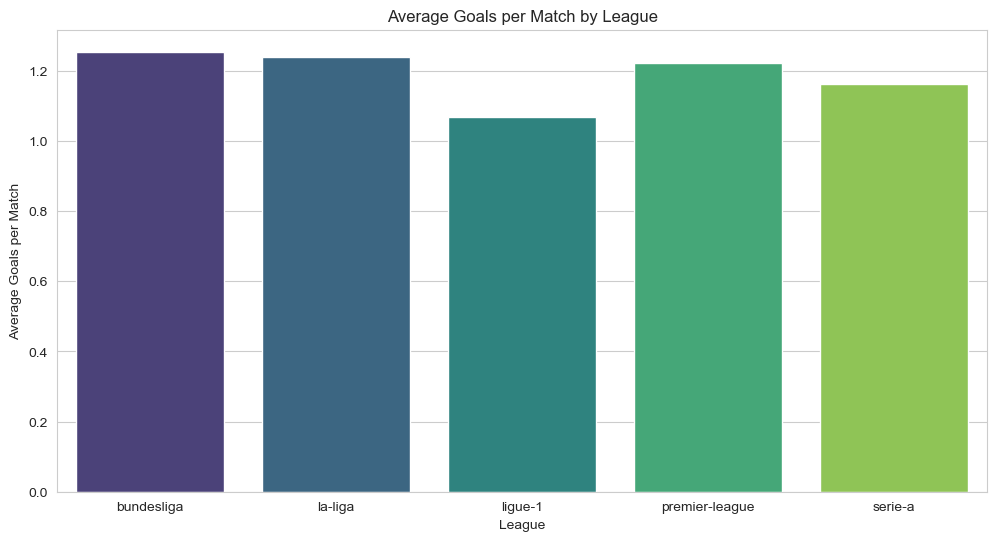

In [27]:
# Average goals per match by league
league_goals = train_data.groupby('league').agg({'HTHG': 'mean', 'HTAG': 'mean'}).reset_index()
league_goals['TotalGoals'] = league_goals['HTHG'] + league_goals['HTAG']

plt.figure(figsize=(12, 6))
sns.barplot(x='league', y='TotalGoals', data=league_goals, palette='viridis')
plt.title('Average Goals per Match by League')
plt.xlabel('League')
plt.ylabel('Average Goals per Match')
plt.show()

##### Key insights

- **Average Goals per Match**: There are noticeable differences in the average number of goals scored per match across different leagues.
    - Bundesliga and La Liga have the highest average goals per match.
    - Ligue 1 has the lowest average goals per match.
    - this may be due to the play styles of the teams.leagues like bundesliga,EPL,la liga may have offensive-style players, while Ligue 1 may have a more balanced play.


<Figure size 1200x600 with 0 Axes>

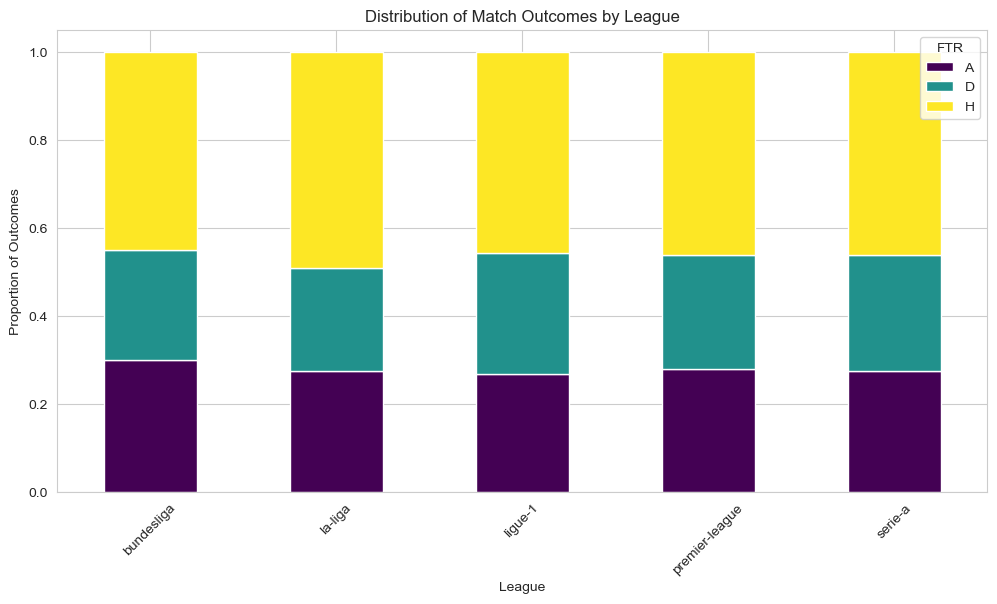

FTR                    A         D         H
league                                      
bundesliga      0.300654  0.248833  0.450514
la-liga         0.275564  0.234586  0.489850
ligue-1         0.268522  0.275668  0.455810
premier-league  0.279323  0.260150  0.460526
serie-a         0.275291  0.263633  0.461076

In [28]:
# Distribution of match outcomes by league
league_outcomes = train_data.groupby('league')['FTR'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(12, 6))
league_outcomes.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Distribution of Match Outcomes by League')
plt.xlabel('League')
plt.ylabel('Proportion of Outcomes')
plt.xticks(rotation=45)
plt.show()

league_outcomes

##### Key insights

- **Distribution of Match Outcomes**: The distribution of home wins, draws, and away wins varies across leagues.
    1. La Liga has the highest proportion of home wins
    2. Ligue 1 has the highest proportion of draws

This indicates some leagues have better home advantage, while some may balanced performance in all fields

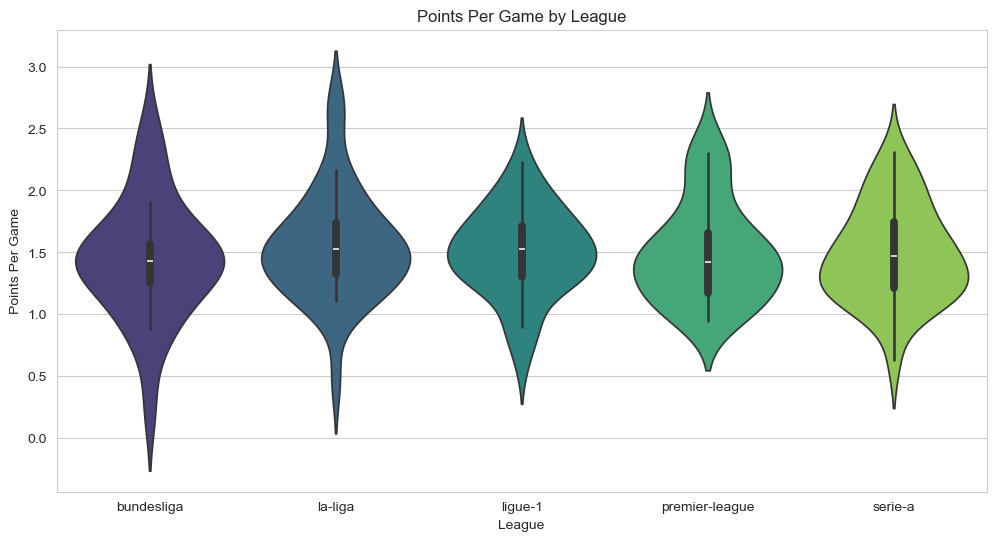

league       HomeTeam  Points  Date  PointsPerGame
0    bundesliga       Augsburg     112    85       1.317647
1    bundesliga  Bayern Munich     300   119       2.521008
2    bundesliga         Bochum      12    17       0.705882
3    bundesliga      Darmstadt      33    34       0.970588
4    bundesliga       Dortmund     269   119       2.260504
..          ...            ...     ...   ...            ...
153     serie-a       Sassuolo      85    57       1.491228
154     serie-a          Siena      70    57       1.228070
155     serie-a         Torino     114    76       1.500000
156     serie-a     US Palermo     203   133       1.526316
157     serie-a        Udinese     229   133       1.721805

[158 rows x 5 columns]

In [29]:
# Calculate points per game for each team
team_performance = train_data.copy(deep=True)
team_performance['Points'] = team_performance['FTR'].map({'H': 3, 'D': 1}).fillna(0).astype(int)

team_performance = team_performance.groupby(['league', 'HomeTeam']).agg({
    'Points': 'sum',
    'Date': 'count'
}).reset_index()

team_performance['PointsPerGame'] = team_performance['Points'] / team_performance['Date']

plt.figure(figsize=(12, 6))
sns.violinplot(x='league', y='PointsPerGame', data=team_performance, palette='viridis')
plt.title('Points Per Game by League')
plt.xlabel('League')
plt.ylabel('Points Per Game')
plt.show()

team_performance


##### Key insights

- **Points Per Game by League**

    1. **Bundesliga**: The boxplot shows a wide range of points per game, with teams like Bayern Munich significantly outperforming others. There is a noticeable spread indicating both high-performing teams and those struggling more.
    2. **Premier League**: Similar to the Bundesliga, the Premier League shows a considerable spread in points per game, reflecting the competitive nature of the league.
    3. **La Liga**: The distribution in La Liga suggests a more clustered performance among teams, with fewer outliers and a tighter range of points per game.
    4. **Serie A**: Serie A also shows a range of performance, but not as wide as the Bundesliga or Premier League, indicating a relatively balanced competition.
    5. **Ligue 1**: The points per game in Ligue 1 are somewhat dispersed, with a few teams standing out significantly above the rest.

##### General Observations:

1. **Top Performers**: Teams like Bayern Munich, Barcelona, Real Madrid, Juventus, and PSG consistently show high points per game, reflecting their dominance in their respective leagues.
2. **Competitive Leagues**: The Bundesliga and Premier League exhibit significant variability, indicating a high level of competition where both very high-performing and lower-performing teams coexist.
3. **Balanced Leagues**: La Liga and Serie A show more clustering around the median, suggesting a balanced performance across teams with fewer extreme outliers.
4. **Performance Outliers**: In each league, there are outliers that significantly outperform or underperform compared to the average. These outliers could be key teams to analyze for strategies, transfers, and other factors influencing their performance.

#### Key Match Statistics by League

Is 1 league better than other?

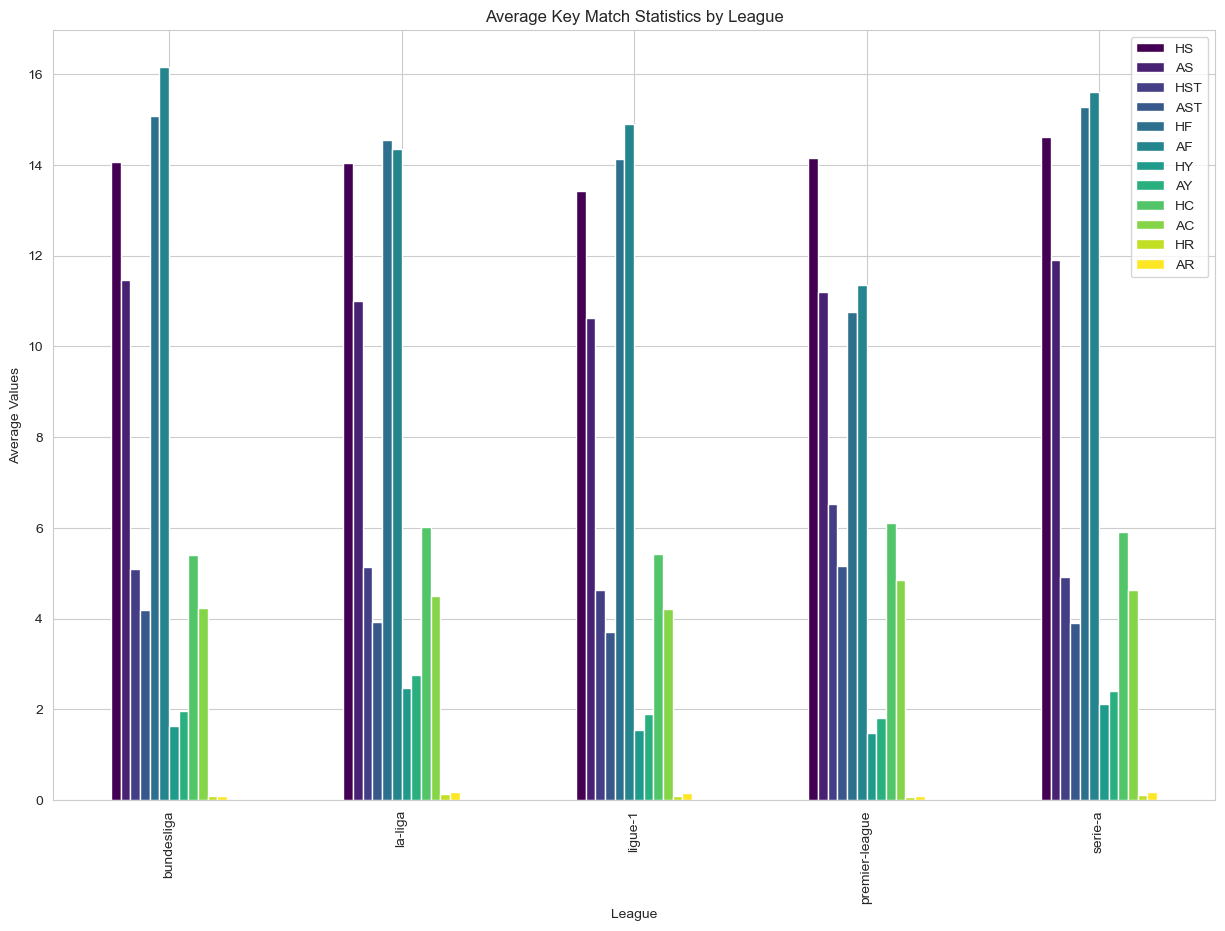

In [30]:
# Average key statistics by league
league_stats = train_data.groupby('league').agg({
    'HS': 'mean',
    'AS': 'mean',
    'HST': 'mean',
    'AST': 'mean',
    'HF': 'mean',
    'AF': 'mean',
    'HY': 'mean',
    'AY': 'mean',
    'HC': 'mean',
    'AC': 'mean',
    'HR': 'mean',
    'AR': 'mean'
}).reset_index()

# Plotting key statistics by league
league_stats.set_index('league').plot(kind='bar', figsize=(15, 10), colormap='viridis')
plt.title('Average Key Match Statistics by League')
plt.xlabel('League')
plt.ylabel('Average Values')
plt.legend(loc='upper right')
plt.show()


 Key match statistics such as shots, shots on target, fouls, and cards show variability across leagues. This can reflect differences in playing styles, referee strictness, and overall game dynamics in each league.

##### Key insights:

- **Average Key Match Statistics by League**
     - **Shots (HS and AS)**:
        - *Premier League*: Shows high average home and away shots compared to other leagues, indicating a high-paced, attacking style of play.
        - *La Liga and Serie A*: These leagues have relatively balanced home and away shots, reflecting a more tactical approach to matches.
        - *Bundesliga*: Exhibits high average shots, especially for home teams, suggesting a strong home advantage.
    - **Shots on Target (HST and AST)**:
        - *Premier League and Bundesliga*: Lead in average shots on target for both home and away teams, reinforcing their attacking nature.
        - *Serie A*: Shows lower averages, indicating a more defensive or controlled style of play.
    - **Fouls (HF and AF)**:
        - *Serie A and La Liga*: Have higher average fouls, which could be indicative of more physical or tightly contested matches.
        - *Premier League and Bundesliga*: Slightly lower averages, possibly reflecting a faster-paced but less physical style.
    - **Yellow Cards (HY and AY)**:
        - *Serie A and La Liga*: Lead in yellow cards, aligning with the higher fouls count.
        - *Premier League and Bundesliga*: Have lower averages, suggesting refereeing style differences or less frequent card issuance.
    - **Corners (HC and AC)**:
        - *Premier League*: High average corners for both home and away teams, indicative of attacking strategies leading to more set-piece opportunities.
        - *Other Leagues*: Show relatively balanced but lower averages.
    - **Red Cards (HR and AR)**:
        - *Serie A and La Liga*: Slightly higher averages, consistent with the higher yellow cards and fouls.
        - *Premier League and Bundesliga*: Lower averages, again reflecting potential refereeing differences or playing style.

##### General Observations:
- **Premier League**: Stands out with high attacking metrics (shots, shots on target, and corners), suggesting a dynamic and offensive style of play.
- **La Liga and Serie A**: Higher fouls and yellow cards indicate more physical matches, with tactical approaches leading to fewer shots but more disciplined defense.
- **Bundesliga**: Shows a strong home advantage in shots and attacking metrics, indicating robust home performances.

#### Disciplinary Actions

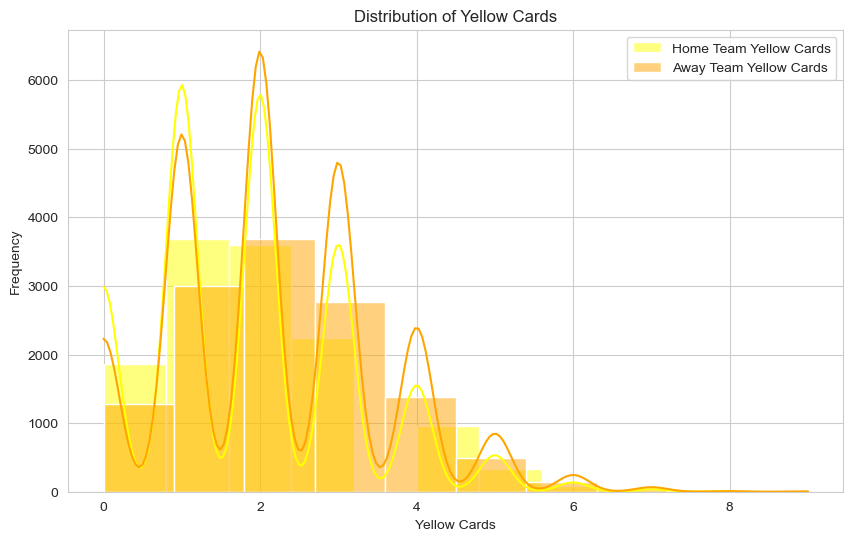

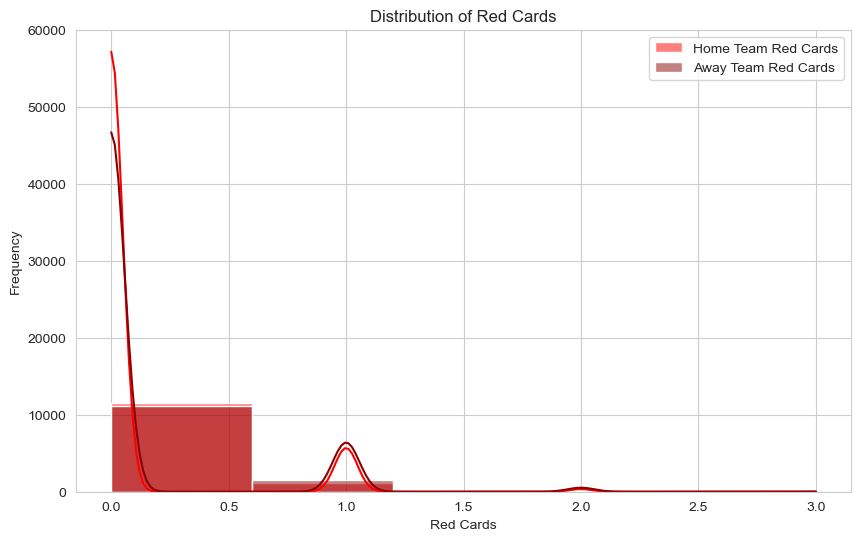

In [31]:
# Yellow cards
plt.figure(figsize=(10, 6))
sns.histplot(train_data['HY'], bins=10, kde=True, color='yellow', label='Home Team Yellow Cards')
sns.histplot(train_data['AY'], bins=10, kde=True, color='orange', label='Away Team Yellow Cards')
plt.title('Distribution of Yellow Cards')
plt.xlabel('Yellow Cards')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Red cards
plt.figure(figsize=(10, 6))
sns.histplot(train_data['HR'], bins=5, kde=True, color='red', label='Home Team Red Cards')
sns.histplot(train_data['AR'], bins=5, kde=True, color='darkred', label='Away Team Red Cards')
plt.title('Distribution of Red Cards')
plt.xlabel('Red Cards')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### Key Insights:

- **Yellow Cards**:
    - The distribution of yellow cards shows that both home and away teams receive yellow cards frequently, with a slightly higher number for home teams.Maybe due to the pressure of winning on the home ground.
- **Red Cards**:
    - The distribution of red cards is less frequent compared to yellow cards, but similarly shows a slightly higher incidence for home teams.

<Figure size 1200x600 with 0 Axes>

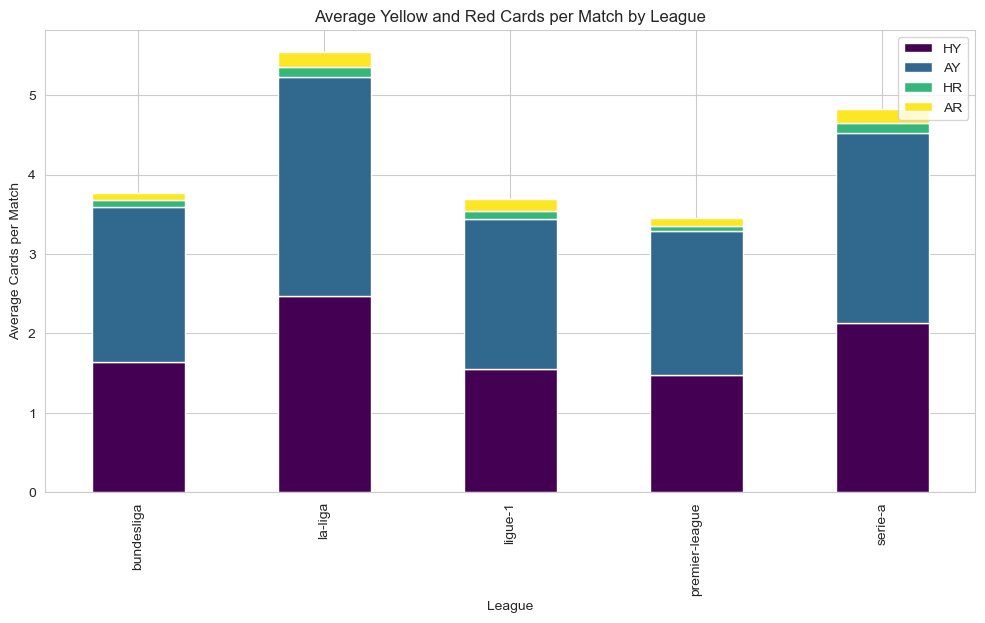

league        HY        AY        HR        AR
0      bundesliga  1.634921  1.962185  0.083567  0.088235
1         la-liga  2.469925  2.760526  0.128571  0.184211
2         ligue-1  1.553968  1.890936  0.100038  0.154193
3  premier-league  1.478571  1.814662  0.065789  0.091353
4         serie-a  2.129748  2.398270  0.124859  0.172245

In [32]:
# Average yellow and red cards per match by league
league_cards = train_data.groupby('league').agg({
    'HY': 'mean',
    'AY': 'mean',
    'HR': 'mean',
    'AR': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
league_cards.set_index('league').plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Average Yellow and Red Cards per Match by League')
plt.xlabel('League')
plt.ylabel('Average Cards per Match')
plt.legend(loc='upper right')
plt.show()

league_cards

##### Key Insights:
- La Liga has the highest number of yellow and red cards, indicating a more physical or stricter officiating style.
- Premier League has the lowest number of cards, suggesting less physicality or lenient officiating.

- How many times did a half time lead result in a win?

In [33]:
# Define a function to categorize match outcomes based on half-time results
def categorize_outcome(HTHG, HTAG, FTR):
    if HTHG > HTAG:
        return 'Home Win' if FTR == 'H' else 'Home Draw' if FTR == 'D' else 'Home Loss'
    elif HTHG < HTAG:
        return 'Away Win' if FTR == 'A' else 'Away Draw' if FTR == 'D' else 'Away Loss'
    else:
        return 'Draw' if FTR == 'D' else 'Home Win' if FTR == 'H' else 'Away Win'

#Apply the function to categorize outcomes
Outcome = train_data.apply(lambda row: categorize_outcome(row['HTHG'], row['HTAG'], row['FTR']), axis=1)

# Filter for cases where there is a half-time lead
ht_lead_data = train_data[(train_data['HTHG'] != train_data['HTAG'])]

# Create a pivot table to summarize the outcomes
pivot_table = ht_lead_data.pivot_table(index=['HTHG', 'HTAG'], columns=Outcome, aggfunc='size', fill_value=0)
total_matches = train_data.shape[0]

pivot_table_percentage = pivot_table.div(total_matches*0.01).reset_index()


print("Half-Time Lead Outcome Proportions:")
pivot_table_percentage

Half-Time Lead Outcome Proportions:


HTHG  HTAG  Away Draw  Away Loss  Away Win  Home Draw  Home Loss  \
0    0.0   1.0   3.513302   1.854460  9.037559   0.000000   0.000000   
1    0.0   2.0   0.414710   0.101721  3.693271   0.000000   0.000000   
2    0.0   3.0   0.031299   0.000000  0.790297   0.000000   0.000000   
3    0.0   4.0   0.007825   0.000000  0.125196   0.000000   0.000000   
4    0.0   5.0   0.000000   0.000000  0.039124   0.000000   0.000000   
5    1.0   0.0   0.000000   0.000000  0.000000   3.998435   1.564945   
6    1.0   2.0   0.571205   0.336463  1.291080   0.000000   0.000000   
7    1.0   3.0   0.054773   0.007825  0.305164   0.000000   0.000000   
8    1.0   4.0   0.007825   0.000000  0.039124   0.000000   0.000000   
9    1.0   5.0   0.000000   0.000000  0.015649   0.000000   0.000000   
10   2.0   0.0   0.000000   0.000000  0.000000   0.414710   0.125196   
11   2.0   1.0   0.000000   0.000000  0.000000   0.539906   0.297340   
12   2.0   3.0   0.023474   0.000000  0.078247   0.000000   0.000000   
13   2.0   4.0   0.000000   0.000000  0.007825   0.000000   0.000000   
14   3.0   0.0   0.000000   0.000000  0.000000   0.007825   0.007825   
15   3.0   1.0   0.000000   0.000000  0.000000   0.062598   0.007825   
16   3.0   2.0   0.000000   0.000000  0.000000   0.023474   0.023474   
17   3.0   4.0   0.000000   0.000000  0.007825   0.000000   0.000000   
18   4.0   0.0   0.000000   0.000000  0.000000   0.000000   0.000000   
19   4.0   1.0   0.000000   0.000000  0.000000   0.007825   0.000000   
20   4.0   2.0   0.000000   0.000000  0.000000   0.007825   0.000000   
21   5.0   0.0   0.000000   0.000000  0.000000   0.000000   0.000000   
22   5.0   1.0   0.000000   0.000000  0.000000   0.000000   0.000000   

     Home Win  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000  
5   15.594679  
6    0.000000  
7    0.000000  
8    0.000000  
9    0.000000  
10   6.909233  
11   2.676056  
12   0.000000  
13   0.000000  
14   1.752739  
15   0.782473  
16   0.109546  
17   0.000000  
18   0.336463  
19   0.109546  
20   0.031299  
21   0.054773  
22   0.031299

##### Key Insights

The table shows the proportions of match outcomes (win, draw, loss) based on half-time goals for both home and away teams. 

1. **High Probability of Home Wins**:
   - When the home team leads at half-time, the proportion of home wins is significantly higher. For example:
     - When the home team leads 1-0 at half-time, the proportion of home wins is approximately 15.6%.
     - When the home team leads 2-0 at half-time, the proportion of home wins increases to approximately 6.9%.
2. **Away Wins with Half-Time Leads**:
   - When the away team leads at half-time, the proportion of away wins is higher. For example:
     - When the away team leads 1-0 at half-time, the proportion of away wins is approximately 9.0%.
     - When the away team leads 2-0 at half-time, the proportion of away wins is approximately 3.7%.
3. **Low Proportion of Draws**:
   - The proportion of draws when either team is leading at half-time is relatively low. For example:
     - When the away team leads 1-0 at half-time, the proportion of draws is approximately 3.5%.
     - When the home team leads 2-1 at half-time, the proportion of draws is approximately 0.5%.
4. **Significance of Goal Margins**:
   - The higher the margin of goals at half-time, the higher the likelihood of the leading team winning the match. For example:
     - When the home team leads 3-0 at half-time, the proportion of home wins is approximately 1.8%.
5. **Rare Occurrences of Large Margins**:
   - Large margins at half-time (e.g., 4-0 or 5-0) are rare and result in almost guaranteed wins for the leading team. For example:
     - When the home team leads 4-0 at half-time, the proportion of home wins is approximately 0.3%.
     - When the away team leads 5-0 at half-time, the proportion of away wins is approximately 0.04%.
6. **Balanced Matches**:
   - For half-time scores of 0-0 (not shown in the table), the outcomes are more evenly distributed between wins, draws, and losses, indicating more balanced matches.

##### General Observation

- A significant lead at half-time often results in a win for the leading team.
- The proportion of draws is relatively low when there is a half-time lead.
- Larger margins at half-time strongly favor the leading team.
- Half-time leads for the home team often translate to full-time wins, but away teams also have a high proportion of converting half-time leads into full-time wins.


### Feature Engineering

- Creating features based on EDA  

#### Rank-Based Features

The function below helps to create a rank based feature based on points earned in the previous years at home and away fields.
 - if the team was not present in the league for the previous year they are given the highest rank.
 - The function also adds a rolling average of previous year ranks based on a window size.

A window 3,5,7 may help in capturing extrinsic factors for longterm and shorterm performances(change in coaches,management,players may reflect an increase or decrease in performance).

In [34]:
def calculate_points_and_rank(df):
 
    df['home_points'] = df['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
    df['away_points'] = df['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))
    
    home_points = df.groupby(['season', 'league', 'HomeTeam'])['home_points'].sum().reset_index()
    away_points = df.groupby(['season', 'league', 'AwayTeam'])['away_points'].sum().reset_index()
    
    home_points.columns = ['season', 'league', 'team', 'home_points']
    away_points.columns = ['season', 'league', 'team', 'away_points']

    total_points = pd.merge(home_points, away_points, on=['season', 'league', 'team'], how='outer').fillna(0)
    total_points['total_points'] = total_points['home_points'] + total_points['away_points']
    
    total_points['home_rank'] = total_points.groupby(['season', 'league'])['home_points'].rank(method='first', ascending=False).astype(int)
    total_points['away_rank'] = total_points.groupby(['season', 'league'])['away_points'].rank(method='first', ascending=False).astype(int)
    total_points['total_rank'] = total_points.groupby(['season', 'league'])['total_points'].rank(method='first', ascending=False).astype(int)
    
    total_points['shifted_season_year'] = total_points['season'].apply(lambda x: str(int(x.split('-')[0]) + 1) + '-' + str(int(x.split('-')[1]) + 1))
    shifted_ranks = total_points[['shifted_season_year', 'league', 'team', 'home_rank', 'away_rank', 'total_rank']].rename(columns={'shifted_season_year': 'season', 'home_rank': 'shifted_home_rank', 'away_rank': 'shifted_away_rank', 'total_rank': 'shifted_total_rank'})
    
    return shifted_ranks

def merge_shifted_ranks(df, shifted_ranks, team_col, home_rank_col, away_rank_col, total_rank_col):
    df = df.copy()  # Avoid modifying the original DataFrame
    df = df.merge(shifted_ranks, left_on=['season', 'league', team_col], right_on=['season', 'league', 'team'], how='left')
    df[home_rank_col] = df['shifted_home_rank']
    df[away_rank_col] = df['shifted_away_rank']
    df[total_rank_col] = df['shifted_total_rank']
    df.drop(columns=['team', 'shifted_home_rank', 'shifted_away_rank', 'shifted_total_rank'], inplace=True)
    return df

def calculate_previous_ranks(train, test):
    train = train.copy()  # Avoid modifying the original DataFrame
    test = test.copy()  # Avoid modifying the original DataFrame

    train['season'] = train['Date'].apply(lambda x: f"{x.year}-{x.year + 1}" if x.month >= 8 else f"{x.year - 1}-{x.year}")
    test['season'] = test['Date'].apply(lambda x: f"{x.year}-{x.year + 1}" if x.month >= 8 else f"{x.year - 1}-{x.year}")
    
    shifted_ranks = calculate_points_and_rank(train)
    
    train = merge_shifted_ranks(train, shifted_ranks, 'HomeTeam', 'previous_home_rank', 'previous_away_rank', 'previous_total_rank')
    train = merge_shifted_ranks(train, shifted_ranks, 'AwayTeam', 'previous_home_rank', 'previous_away_rank', 'previous_total_rank')
    test = merge_shifted_ranks(test, shifted_ranks, 'HomeTeam', 'previous_home_rank', 'previous_away_rank', 'previous_total_rank')
    test = merge_shifted_ranks(test, shifted_ranks, 'AwayTeam', 'previous_home_rank', 'previous_away_rank', 'previous_total_rank')
    
    for league in train['league'].unique():
        max_rank_home = train.loc[train['league'] == league, 'previous_home_rank'].max()
        max_rank_away = train.loc[train['league'] == league, 'previous_away_rank'].max()
        max_rank_total = train.loc[train['league'] == league, 'previous_total_rank'].max()
        
        train.loc[train['league'] == league, 'previous_home_rank'] = train.loc[train['league'] == league, 'previous_home_rank'].fillna(max_rank_home).astype(int)
        train.loc[train['league'] == league, 'previous_away_rank'] = train.loc[train['league'] == league, 'previous_away_rank'].fillna(max_rank_away).astype(int)
        train.loc[train['league'] == league, 'previous_total_rank'] = train.loc[train['league'] == league, 'previous_total_rank'].fillna(max_rank_total).astype(int)
        
        test.loc[test['league'] == league, 'previous_home_rank'] = test.loc[test['league'] == league, 'previous_home_rank'].fillna(max_rank_home).astype(int)
        test.loc[test['league'] == league, 'previous_away_rank'] = test.loc[test['league'] == league, 'previous_away_rank'].fillna(max_rank_away).astype(int)
        test.loc[test['league'] == league, 'previous_total_rank'] = test.loc[test['league'] == league, 'previous_total_rank'].fillna(max_rank_total).astype(int)
    
    return train.drop(['home_points', 'away_points'],axis=1), test

def calculate_rolling_ranks(train, test, window_sizes):
    combined = pd.concat([train, test], ignore_index=True)
    
    combined['season'] = combined['Date'].apply(lambda x: f"{x.year}-{x.year + 1}" if x.month >= 8 else f"{x.year - 1}-{x.year}")
    
    for window in window_sizes:
        combined[f'RollingRank_Home_{window}'] = combined.groupby(['HomeTeam'])['previous_home_rank'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        combined[f'RollingRank_Away_{window}'] = combined.groupby(['AwayTeam'])['previous_away_rank'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        combined[f'RollingRank_Total_{window}'] = combined.groupby(['HomeTeam', 'AwayTeam'])['previous_total_rank'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        
    train = combined.loc[combined.index < len(train)].reset_index(drop=True)
    test = combined.loc[combined.index >= len(train)].reset_index(drop=True)
    
    return train, test

In [35]:
# Apply the feature engineering function
window_sizes = [3, 5, 7]

train_data, test_data = calculate_previous_ranks(train_data, test_data)
train_data, test_data = calculate_rolling_ranks(train_data, test_data, window_sizes)

#### Current Form

As the Test Dataset don't have FTR as a variable. The following code allows us to capture the current form of the team based on Haltime goals.the feature include days since last games played,avg goals till now,avg goals conceded and recent average of it all.

- **Days_Since_Last_Game**: Days elapsed since the last home and away games for each team.this may indicate rest and recovery time, affecting player fitness and readiness.
- **Games_Count**: Cumulative count of games played at home and away for each team.
- **Corner_Ratio**: Ratio of corners taken by the home and away teams relative to total corners (home + away).Reflects team's attacking strategies and ability to create scoring opportunities 
- **Total_Goals**: Cumulative goals scored by home and away teams across matches.
- **Total_Shots_On_Target**: Cumulative shots on target by home and away teams.
- **Recent_Goals**: Sum of goals scored by home and away teams in the last 5 matches (rolling window).
- **Recent_Shots_On_Target**: Sum of shots on target by home and away teams in the last 5 matches (rolling window).
- **Total_Goals_Conceded**: Cumulative goals conceded by home and away teams across matches.
- **Recent_Goals_Conceded**: Sum of goals conceded by home and away teams in the last 5 matches (rolling window).


In [36]:
def add_recent_form_features(df):
    
    # Time since last played home and away game
    df['Last_Home_Game'] = df.groupby(['HomeTeam','season'])['Date'].shift(1)
    df['Days_Since_Last_Home_Game'] = (df['Date'] - df['Last_Home_Game']).dt.days.fillna(0).astype(int)
    df['Last_Away_Game'] = df.groupby(['AwayTeam','season'])['Date'].shift(1)
    df['Days_Since_Last_Away_Game'] = (df['Date'] - df['Last_Away_Game']).dt.days.fillna(0).astype(int)

    # Number of home and away games
    df['Home_Games_Count'] = df.groupby(['HomeTeam','season']).cumcount() + 1
    df['Away_Games_Count'] = df.groupby(['AwayTeam','season']).cumcount() + 1

    # Corner opportunities
    df['Home_Corner_ratio'] = df['HC'] / (df['HC'] + df['AC'] + 0.01)
    df['Away_Corner_ratio'] = df['AC'] / (df['HC'] + df['AC'] + 0.01)

    # Teams offense
    df['Total_Home_Goals'] = df.groupby(['HomeTeam','season'])['HTHG'].cumsum()
    df['Total_Away_Goals'] = df.groupby(['AwayTeam','season'])['HTAG'].cumsum()
    df['Total_Home_Shots_On_Target'] = df.groupby(['HomeTeam', 'season'])['HST'].cumsum()
    df['Total_Away_Shots_On_Target'] = df.groupby(['AwayTeam', 'season'])['AST'].cumsum()
    df['Recent_Home_Goals'] = df.groupby(['HomeTeam','season'])['HTHG'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())
    df['Recent_Away_Goals'] = df.groupby(['AwayTeam','season'])['HTAG'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())
    df['Recent_Home_Shots_On_Target'] = df.groupby(['HomeTeam', 'season'])['HST'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())
    df['Recent_Away_Shots_On_Target'] = df.groupby(['AwayTeam', 'season'])['AST'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())

    # Teams defense
    df['Total_Home_Goals_Conceded'] = df.groupby(['HomeTeam','season'])['HTAG'].cumsum()
    df['Total_Away_Goals_Conceded'] = df.groupby(['AwayTeam','season'])['HTHG'].cumsum()
    df['Recent_Home_Goals_Conceded'] = df.groupby(['HomeTeam','season'])['HTAG'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())
    df['Recent_Away_Goals_Conceded'] = df.groupby(['AwayTeam','season'])['HTHG'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())

    return df.drop(['Last_Home_Game','Last_Away_Game'],axis=1)

In [37]:
# Apply the key stats features
train_data = add_recent_form_features(train_data)
test_data = add_recent_form_features(test_data)

#### Key-Statistical Features

We use key statistics to create more general functions
- **Shot_Accuracy**: Ratio of shots on target to total shots for both home and away teams.
- **Corner_to_Shot_Ratio**: Ratio of corners to total shots for both home and away teams.
- **Fouls_to_Cards**: Ratio of fouls committed to total cards (yellow + red) for both home and away teams.
- **Intensity**: Sum of shots, corners, and fouls for both home and away teams.
- **Cumulative Features**: Cumulative sum of each key statistic (shot accuracy, corner to shot ratio, fouls to cards, intensity) up to each match for the season.
- **Rolling Features**: Rolling average (mean) of each key statistic over a specified window size, updating with each match.

In [38]:
#Key stats based features
def add_key_stats_features(df):
    df['Home_Shot_Accuracy'] = df['HST'] / (df['HS'] + 0.01)
    df['Away_Shot_Accuracy'] = df['AST'] / (df['AS'] + 0.01)
    df['Home_Corner_to_Shot_Ratio'] = df['HC'] / (df['HS'] + 0.01)
    df['Away_Corner_to_Shot_Ratio'] = df['AC'] / (df['AS'] + 0.01)
    df['Home_Fouls_to_Cards'] = df['HF'] / (df['HY'] + df['HR'] + 0.01)
    df['Away_Fouls_to_Cards'] = df['AF'] / (df['AY'] + df['AR'] + 0.01)
    df['Home_Intensity'] = df['HS'] + df['HC'] + df['HF']
    df['Away_Intensity'] = df['AS'] + df['AC'] + df['AF']
    return df

def calculate_cumulative_and_rolling_features(df, window=5):  
    key_stats = ['Home_Shot_Accuracy', 'Away_Shot_Accuracy', 'Home_Corner_to_Shot_Ratio', 
                 'Away_Corner_to_Shot_Ratio', 'Home_Fouls_to_Cards', 'Away_Fouls_to_Cards', 'Home_Intensity', 
                 'Away_Intensity']
    
    for stat in key_stats:
        if 'Home' in stat:
            df[f'Cumulative_{stat}'] = df.groupby(['league', 'season', 'HomeTeam'])[stat].cumsum()
            df[f'Rolling_{stat}_{window}'] = df.groupby(['league', 'season', 'HomeTeam'])[stat].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        elif 'Away' in stat:
            df[f'Cumulative_{stat}'] = df.groupby(['league', 'season', 'AwayTeam'])[stat].cumsum()
            df[f'Rolling_{stat}_{window}'] = df.groupby(['league', 'season', 'AwayTeam'])[stat].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    
    return df

In [39]:
# Apply the key stats features
train_data = add_key_stats_features(train_data)
test_data = add_key_stats_features(test_data)

# Calculate cumulative and rolling features
train_data = calculate_cumulative_and_rolling_features(train_data, window=5)
test_data = calculate_cumulative_and_rolling_features(test_data, window=5)

#### Seasonal Features

The `time_of_year` feature may be crucial due to its influence on weather conditions, player fitness and form, tactical adjustments, fixture congestion, and psychological factors across different seasons.

In [40]:
# 4. Match Context
def time_of_year(date):
    if date.month in [8, 9, 10, 11]:
        return 1 #'Early'
    elif date.month in [12, 1, 2, 3]:
        return 2 #'Mid'
    else:
        return 3 #'Late'        

In [41]:
train_data['TimeOfYear'] = train_data['Date'].apply(time_of_year)
test_data['TimeOfYear'] = test_data['Date'].apply(time_of_year)

#### Categorical Encoding

Each league is different with showing key statistics,hence it can be label encoded and can be checked if the model finds it important

In [41]:
# Encode League Information
train_data['league'] = train_data['league'].astype('category').cat.codes
test_data['league'] = test_data['league'].astype('category').cat.codes

#### Saninty Checks

The following function checks if categories contain duplicate mapping.(ie A contains values -> 0,1 and B also contains -> 0,1 and if A(0)->B(0) & A(1)->B(1) it will identify it as duplicate mapping)

In [42]:
def get_duplicate_mapping(df):
    duplicate_features_groups = []
    checked_features = set()

    for i, feature1 in enumerate(df.columns):
        if feature1 not in checked_features:
            duplicates = [feature1]
            for feature2 in df.columns[i + 1:]:
                if feature2 not in checked_features:
                    if df[feature1].nunique(dropna=False) == df[feature2].nunique(dropna=False):
                        if df[feature1].equals(df[feature2]):
                            duplicates.append(feature2)
                        elif df[[feature1, feature2]].drop_duplicates().shape[0] == df[feature1].nunique(dropna=False):
                            duplicates.append(feature2)
            if len(duplicates) > 1:
                duplicate_features_groups.append(duplicates)
                checked_features.update(duplicates)

    return duplicate_features_groups

In [44]:
get_duplicate_mapping(train_data)

[]

The function below optimises the datatype in the train and test dataset.

In [45]:
def optimize_dataset(df):
    
    # Iterate over each column
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'float64' or col_type == 'float32':
            
            # Check if float columns can be safely converted to integers
            if pd.Series(df[col]).dropna().apply(float.is_integer).all():
                df[col] = df[col].astype('int32')
            else:
                # Downcast float64/float32 to float32 if not integer
                df[col] = pd.to_numeric(df[col], downcast='float')
        
        elif col_type == 'int64' or col_type == 'int32':
            # Downcast int64/int32 to the smallest possible integer type
            if df[col].max() <= np.iinfo(np.int8).max and df[col].min() >= np.iinfo(np.int8).min:
                df[col] = df[col].astype('int8')
            elif df[col].max() <= np.iinfo(np.int16).max and df[col].min() >= np.iinfo(np.int16).min:
                df[col] = df[col].astype('int16')
            else:
                df[col] = df[col].astype('int32')
        
        elif col_type == 'object':
            
            # Convert object types to category if the number of unique values is less than 50% of total rows
            if df[col].nunique() / len(df) < 0.5:
                df[col] = df[col].astype('category')

    # Additionally, convert boolean columns to int8
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype('int8')
    
    return df

In [46]:
train_data = optimize_dataset(train_data)
test_data = optimize_dataset(test_data)

### Modeling

- There are multiple models to consider (logistic regression, Naive Bayes, rule-based classifiers, gradient boosting). However, due to the complex nature of football matches with numerous unknowns, outliers, and high granularity, simple models like logistic regression and Naive Bayes may struggle to capture these complexities effectively. In contrast, robust models such as gradient boosting are preferable due to their ability to handle diverse and complex data with minimal preprocessing, ensuring better generalization across different match scenarios.
- For evaluation, precision will serve as our primary metric for classification. We will also examine the classification report, confusion matrix, and AUC-ROC curve to compare models comprehensively and assess for potential overfitting, adjusting our approach if better solutions arise.
- For Feature Selection there are various ways(ranking filter methods,correlation methods, domain expertise, elimination methods.etc) but I have chosen to skip it as we have around 70 features and 10955 samples, hence we can do it after fine-tuning by looking at feature importance.
- For feature selection I will just use grid search although there are better ways like exploring some grid based on intution and then trying some bayesian optimisation by given the scope of this excercise I will  skip it

In [47]:
NIR = (train_data['FTR'].value_counts().max() / len(train_data)) #Net information rate
print(f"Random guessing the accuracy of home wins should be: {round(NIR,2)}")

Random guessing the accuracy of home wins should be: 0.46


In [48]:
le = LabelEncoder()

# Split the data based on the season
X_train = train_data[train_data['season'] != '2016-2017'].drop(columns=['FTR', 'season', 'HomeTeam', 'AwayTeam','Date'])
y_train = train_data[train_data['season'] != '2016-2017']['FTR']
y_train = le.fit_transform(y_train)
X_test = train_data[train_data['season'] == '2016-2017'].drop(columns=['FTR', 'season', 'HomeTeam', 'AwayTeam','Date'])
y_test = train_data[train_data['season'] == '2016-2017']['FTR']
y_test = le.fit_transform(y_test)


In [49]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5):
    # Cross-validation predictions with precision as the scoring metric
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=9)
    y_train_pred_proba_cv = cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    
    # Evaluation metrics
    precision = precision_score(y_test, y_test_pred, average='macro')
    recall = recall_score(y_test, y_test_pred, average='macro')
    f1 = f1_score(y_test, y_test_pred, average='macro')

    # Binarize the output for multi-class ROC AUC
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_train_pred_proba_cv_bin = label_binarize(np.argmax(y_train_pred_proba_cv, axis=1), classes=[0, 1, 2])
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Compute ROC curve and ROC area for training set
    fpr_train, tpr_train, _ = roc_curve(y_train_bin.ravel(), y_train_pred_proba.ravel())
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for cross-validated training set
    fpr_cv, tpr_cv, _ = roc_curve(y_train_bin.ravel(), y_train_pred_proba_cv.ravel())
    roc_auc_cv = auc(fpr_cv, tpr_cv)

    print("Model Performance on Test Set:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score (macro):", roc_auc["macro"])
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    
    # Cross-validated precision score
    precision_cv = cross_val_score(model, X_train, y_train, cv=skf, scoring='precision_macro')
    print("Cross-validated Precision scores:", precision_cv)
    print("Mean Cross-validated Precision score:", precision_cv.mean())
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"], label='Test ROC curve (macro) (area = %0.2f)' % roc_auc["macro"])
    plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_cv, tpr_cv, lw=2, linestyle='--', label='CV ROC curve (area = %0.2f)' % roc_auc_cv)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return precision, recall, f1, precision_cv.mean(), roc_auc["macro"], cm

- let's build a baseline with Random forest

Model Performance on Test Set:
Precision: 0.6229932129155537
Recall: 0.6140619435101012
F1 Score: 0.6065643185242942
ROC AUC Score (macro): 0.826390062853743

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.75      0.71       516
           1       0.46      0.25      0.33       421
           2       0.73      0.84      0.78       888

    accuracy                           0.68      1825
   macro avg       0.62      0.61      0.61      1825
weighted avg       0.65      0.68      0.66      1825

Cross-validated Precision scores: [0.60248643 0.58343097 0.6102012  0.5886317  0.59362787]
Mean Cross-validated Precision score: 0.5956756332284292


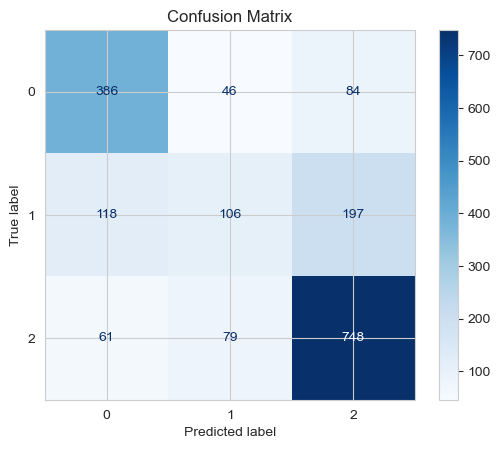

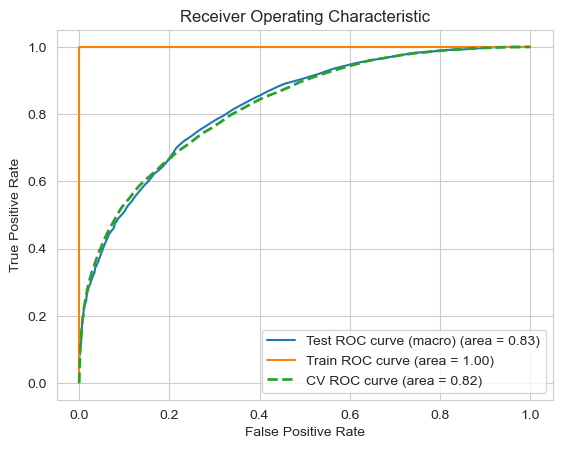

In [50]:
# Evaluate Random Forest with class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test, cv=5)

- here 0 represents away win,2 represents home win and 1 represents draw
- This model seems to be overfitting, let's improve it by finetuning it with grid search.

In [55]:
rf_param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [10, 20, 30],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'class_weight': ['balanced']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=cv, n_jobs=-1, scoring='precision')
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='precision_macro')

In [52]:
# rf_best_params = rf_grid_search.best_params_
# rf_best_model = rf_grid_search.best_estimator_
# print("Best parameters found: ", rf_best_params)
rf_best_model = RandomForestClassifier(random_state=42, n_estimators=300, class_weight='balanced', max_depth=10 ,min_samples_leaf=4 ,min_samples_split=2)
print("Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}")

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


Model Performance on Test Set:
Precision: 0.6296195018112852
Recall: 0.6377672209026128
F1 Score: 0.6325530729524823
ROC AUC Score (macro): 0.8344008546638162

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70       516
           1       0.42      0.41      0.42       421
           2       0.80      0.75      0.77       888

    accuracy                           0.67      1825
   macro avg       0.63      0.64      0.63      1825
weighted avg       0.67      0.67      0.67      1825

Cross-validated Precision scores: [0.61827278 0.60081134 0.61885525 0.61422503 0.60588286]
Mean Cross-validated Precision score: 0.6116094533680269


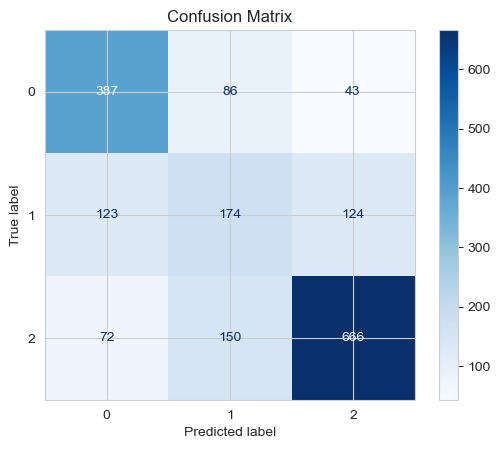

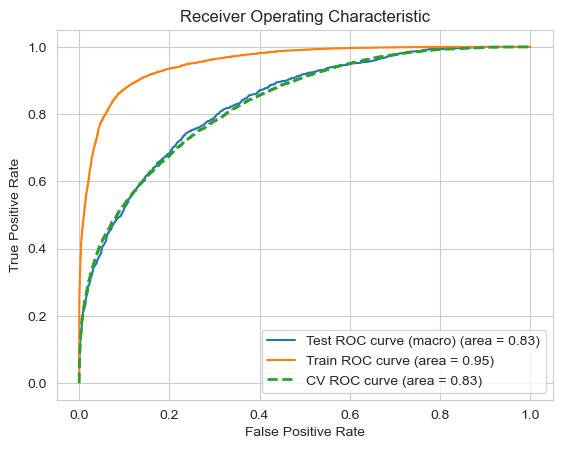

In [53]:
rf_results_tuned = evaluate_model(rf_best_model, X_train, y_train, X_test, y_test, cv=5)

- This model generalises better than the untuned model and have better precision
- now lets try a boosting model and check if it does better

Model Performance on Test Set:
Precision: 0.6236978466090669
Recall: 0.6224434952546315
F1 Score: 0.6222201618746416
ROC AUC Score (macro): 0.8214536093474785

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.71       516
           1       0.42      0.36      0.39       421
           2       0.75      0.80      0.77       888

    accuracy                           0.67      1825
   macro avg       0.62      0.62      0.62      1825
weighted avg       0.66      0.67      0.67      1825

Cross-validated Precision scores: [0.60812182 0.58614574 0.58236271 0.58102624 0.59025528]
Mean Cross-validated Precision score: 0.5895823569106479


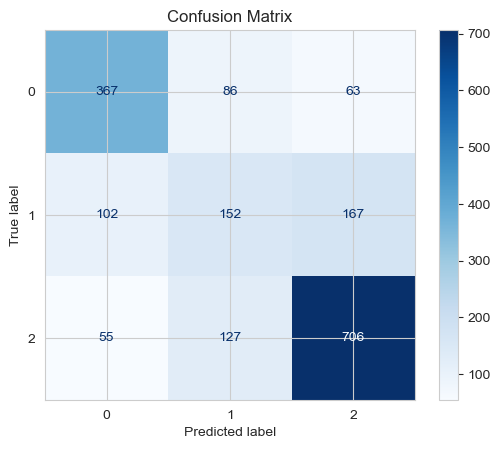

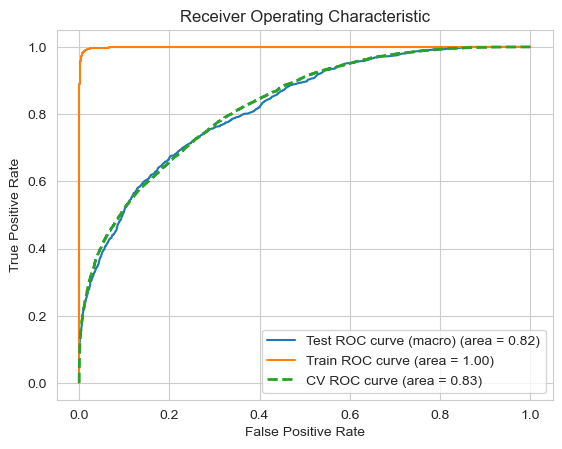

In [54]:
class_weights = pd.Series(y_train).value_counts().max() / pd.Series(y_train).value_counts()
scale_pos_weight = {i: class_weights[i] for i in range(len(class_weights))}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=scale_pos_weight, random_state=42)
xgb_results = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, cv=5)

In [55]:
xgb_param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [3, 5, 7],
'learning_rate': [0.01, 0.1, 0.2],
'subsample': [0.8, 1.0],
'colsample_bytree': [0.8, 1.0],
'scale_pos_weight': [scale_pos_weight]
}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)

xgb_grid_search = GridSearchCV(estimator = xgb_model, param_grid=xgb_param_grid, cv=cv, n_jobs=-1, scoring='precision_macro')
xgb_grid_search.fit(X_train, y_train)

/Users/luv/miniconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:42:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397655897/work/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luv/miniconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:42:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397655897/work/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luv/miniconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:42:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397655897/work/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luv/miniconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:42:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397655897

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [{0: 1.6534426229508197,
                                               1: 1.7620545073375262, 2: 1.0}],
                         'subsample': [0.8, 1.0]},
             scoring='precision_macro')

In [56]:
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_
print("Best parameters found: ", xgb_best_params)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': {0: 1.6534426229508197, 1: 1.7620545073375262, 2: 1.0}, 'subsample': 0.8}


Model Performance on Test Set:
Precision: 0.6221560949654578
Recall: 0.623700856576623
F1 Score: 0.6196447784174881
ROC AUC Score (macro): 0.8367599601242948

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71       516
           1       0.42      0.31      0.36       421
           2       0.76      0.82      0.79       888

    accuracy                           0.68      1825
   macro avg       0.62      0.62      0.62      1825
weighted avg       0.66      0.68      0.67      1825

Cross-validated Precision scores: [0.63438158 0.60664589 0.61322469 0.6209379  0.59059206]
Mean Cross-validated Precision score: 0.613156424517867


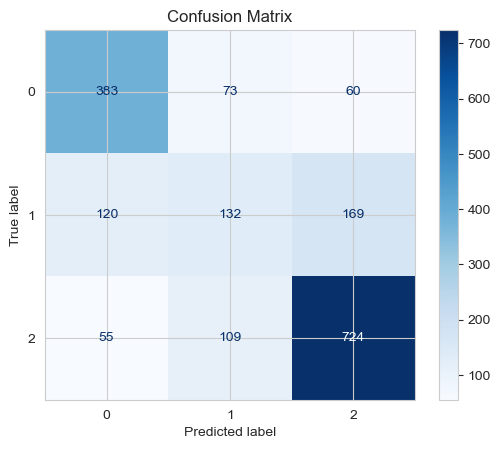

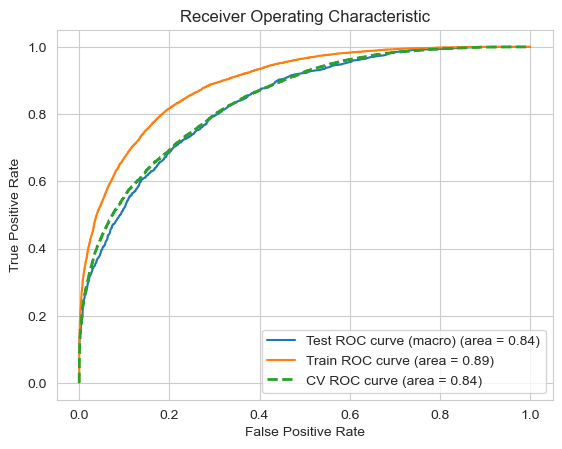

In [57]:
xgb_results_tuned = evaluate_model(xgb_best_model, X_train, y_train, X_test, y_test, cv=5)

- This model generalises better as evident from the AUC-ROC curve 
- The precision for home wins are better here, although there is some loss in precision for draws and losses
- We will proceed with this model

### Model Validation

#### Examining Feature Importance

In [58]:
def plot_feature_importances(classifier, feature_names, title):
        
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), names, rotation=90)
    
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()  
    
    plt.show()

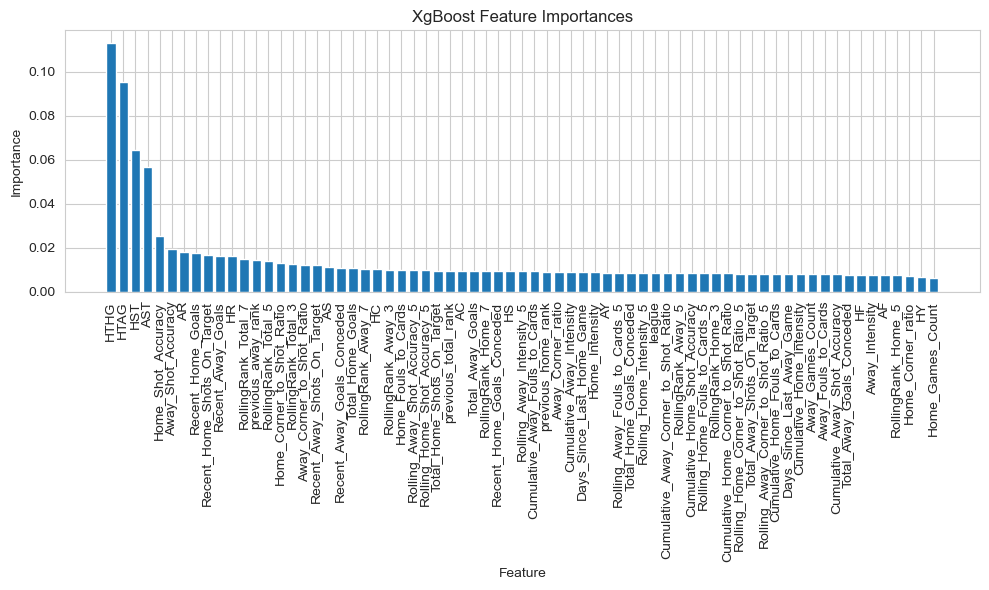

In [59]:
plot_feature_importances(xgb_best_model, X_train.columns, 'XgBoost Feature Importances')

#### Key Takeaways
- it seems model half time goals and shots on target and its derivatives to be important factors in this decision
- rolling rank of 7 amongst the other seem years also rank high in feature importance indicating well performing stable teams/rosters are more likely to dominate
- red cards at home also seems like an important factor.In general when hometeams start commiting serious fouls they might be at the loosing end
- recent home goals that are conceded to the away team shows the importance of defense in the game
- Total home goals also seem like a decisive factor. As the increase in the number home goals over season is reflective of strong performance.
- Time of year seems unimportant to the model in deciding the winner

#### Examining Shap Importance

In [106]:
shap_values = shap.TreeExplainer(xgb_best_model).shap_values(X_test)

num_classes = shap_values.shape[2]
class_names = ["Away Win", "Draw", "Home win"]

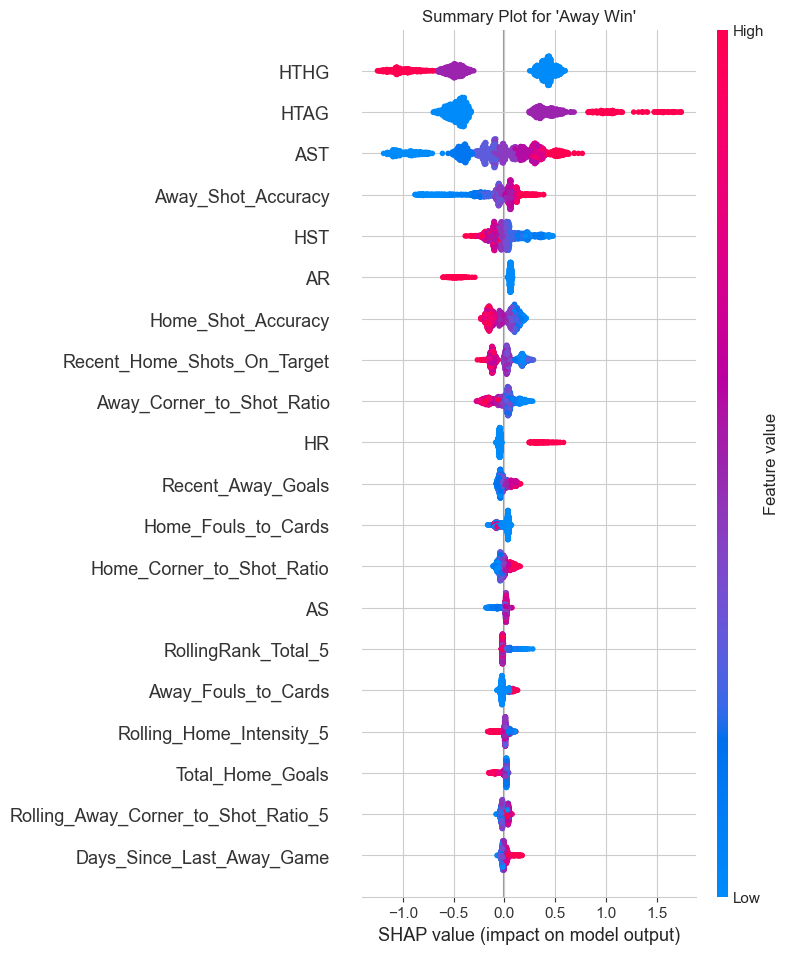

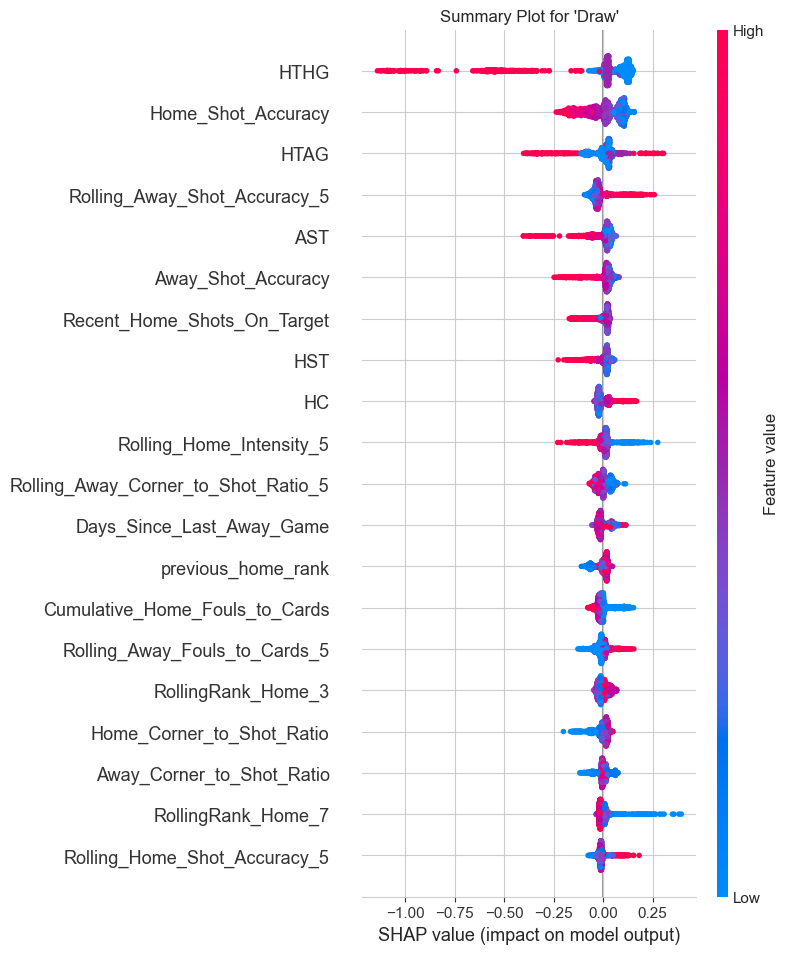

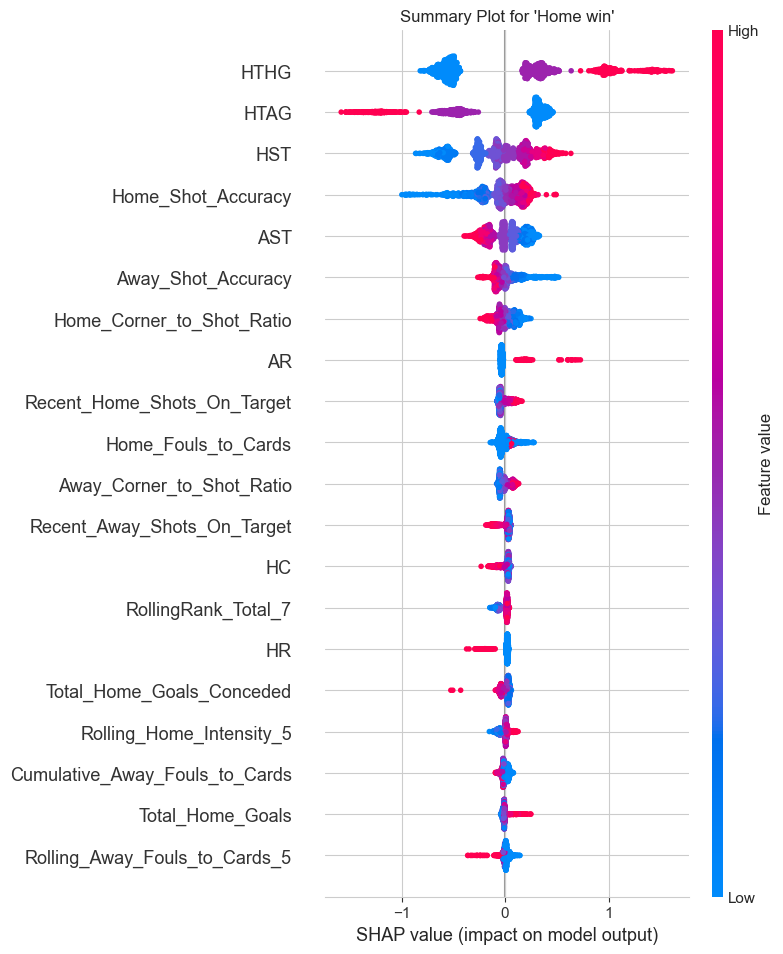

In [107]:
for class_idx in range(num_classes):
    class_shap_values = shap_values[:, :, class_idx]

    # Create summary plot for each class
    shap.summary_plot(class_shap_values, X_test, feature_names=X_test.columns, show=False)
    plt.title(f"Summary Plot for '{class_names[class_idx]}'")
    plt.show()


- Shap importance almost gives the same result for top factors for our model.
- The function below explores interactions between top 2 influencing features

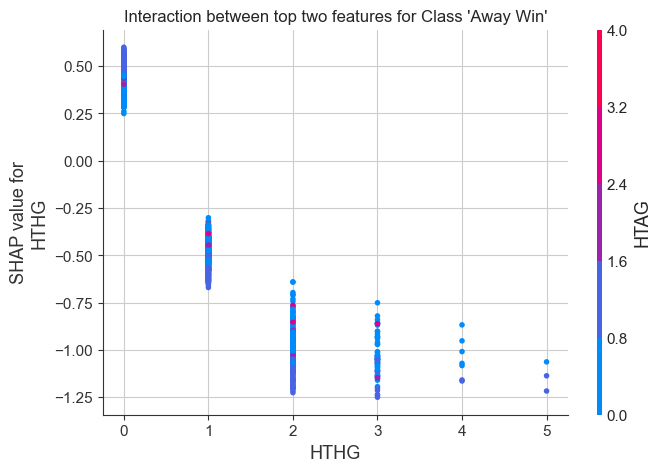

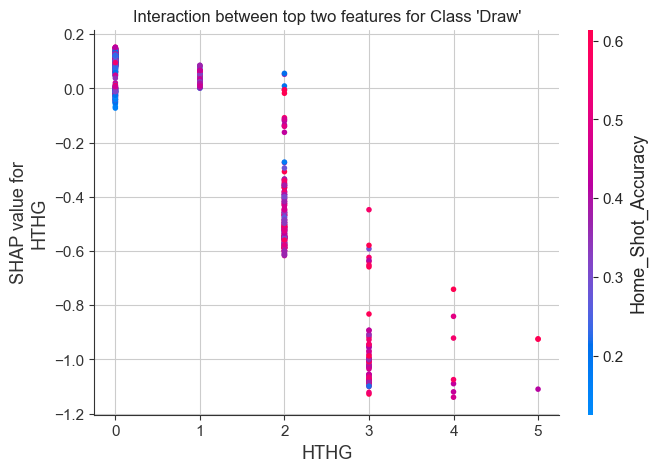

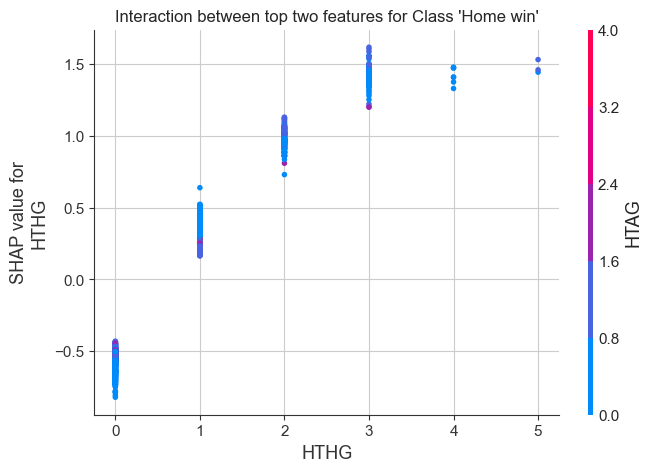

In [109]:
for class_idx in range(num_classes):
    class_shap_values = shap_values[:, :, class_idx]
    
    # Get the top two features for this class
    shap_abs_mean = np.abs(class_shap_values).mean(axis=0)
    top_two_features = np.argsort(shap_abs_mean)[-2:]
    
    # Plot interaction between the top two features
    shap.dependence_plot(
        top_two_features[1],
        class_shap_values,
        X_test,
        interaction_index=top_two_features[0],
        feature_names=X_test.columns,
        show=False
    )
    plt.title(f"Interaction between top two features for Class '{class_names[class_idx]}'")
    plt.show()

- based on the insights from the interaction plots we can examine the top features

In [115]:
def Explore_interaction(df):
    # Difference in Half-Time Goals
    df['HT_Diff'] = df['HTHG'] - df['HTAG']
    
    # Product of Half-Time Goals and Home Shot Accuracy
    df['HTHG_HomeShotAcc'] = df['HTHG'] * df['Home_Shot_Accuracy']
    
    # Cumulative Half-Time Goals
    df['HT_Total_Goals'] = df['HTHG'] + df['HTAG']
    
    # Normalized Half-Time Goals
    df['Norm_HTHG'] = df['HTHG'] / (df['Home_Shot_Accuracy'] + 1e-9)
    df['Norm_HTAG'] = df['HTAG'] / (df['Away_Shot_Accuracy'] + 1e-9)  # Assuming you have Away_Shot_Accuracy
    
    # Half-Time Goal Ratio
    df['HT_Goal_Ratio'] = df['HTHG'] / (df['HTAG'] + 1e-9)
    
    # More interaction features
    df['HTHG_HTAG_Interaction'] = df['HTHG'] * df['HTAG']
    df['HTHG_HomeShotAcc_Interaction'] = df['HTHG'] * df['Home_Shot_Accuracy']
    df['HTAG_HomeShotAcc_Interaction'] = df['HTAG'] * df['Home_Shot_Accuracy']

    #Possibly add more cumalative terms
    return df
    

In [ ]:
# X_train = Explore_interaction(X_train)
# X_test = Explore_interaction(X_test)

- lets also examine the top 10 missclassified examples

Top 10 misclassified examples for class 'Away Win':
Decision Plot for Misclassified Example 9 in Class 'Away Win'


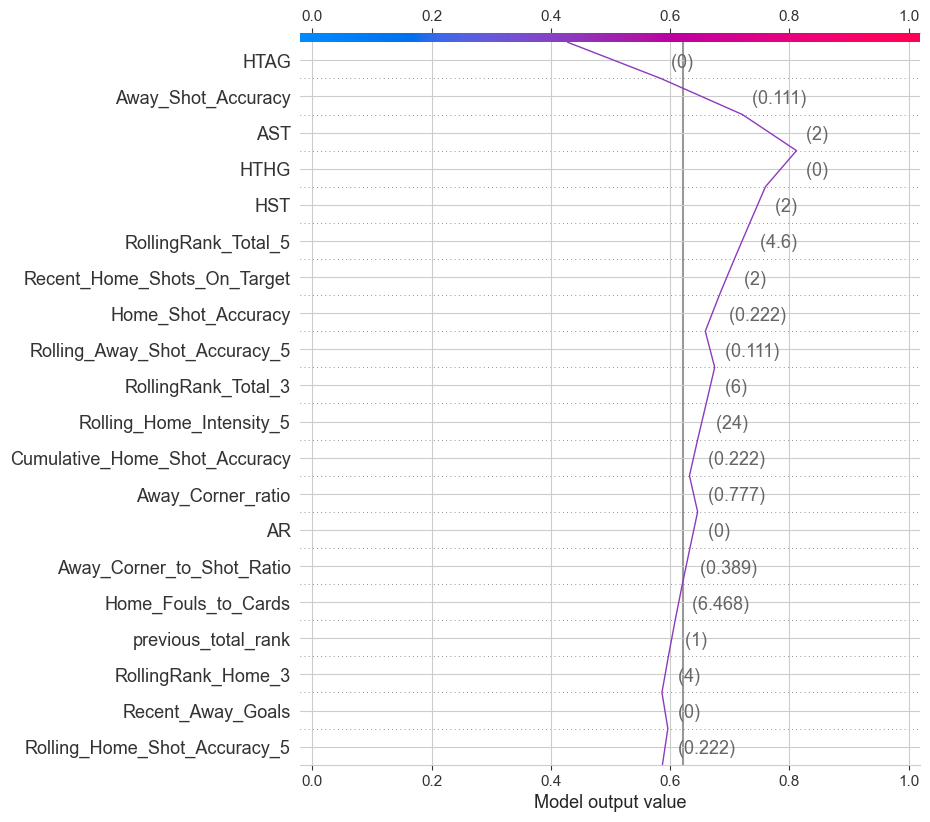

Decision Plot for Misclassified Example 17 in Class 'Away Win'


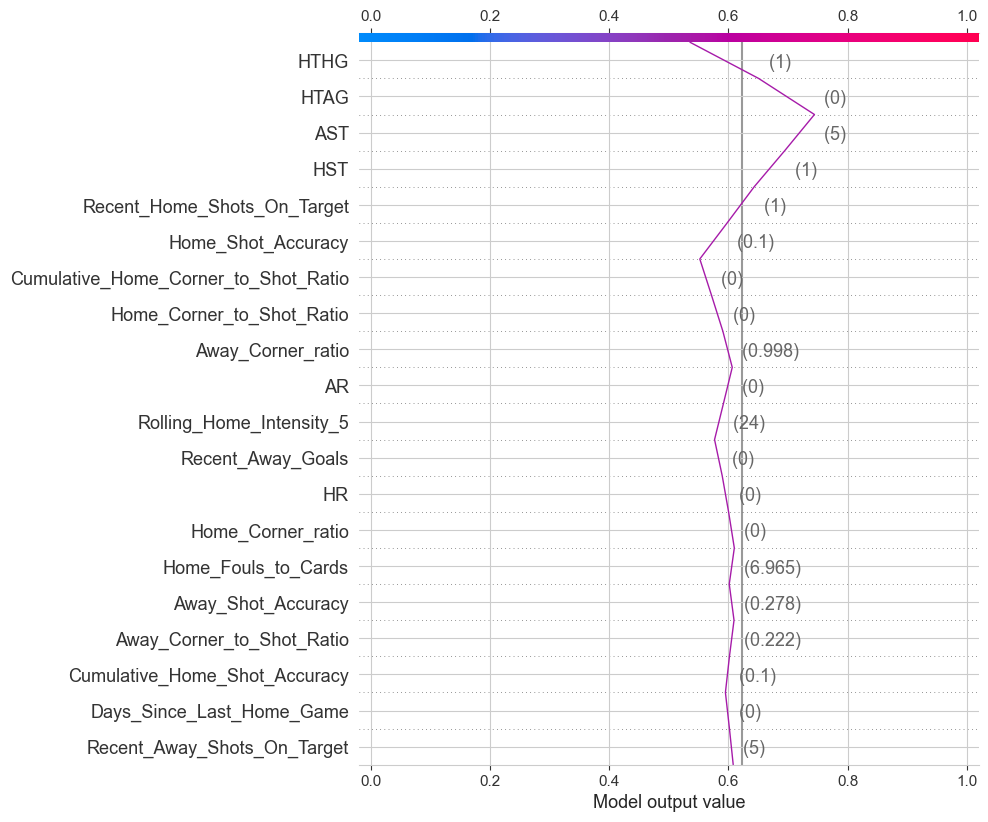

Decision Plot for Misclassified Example 25 in Class 'Away Win'


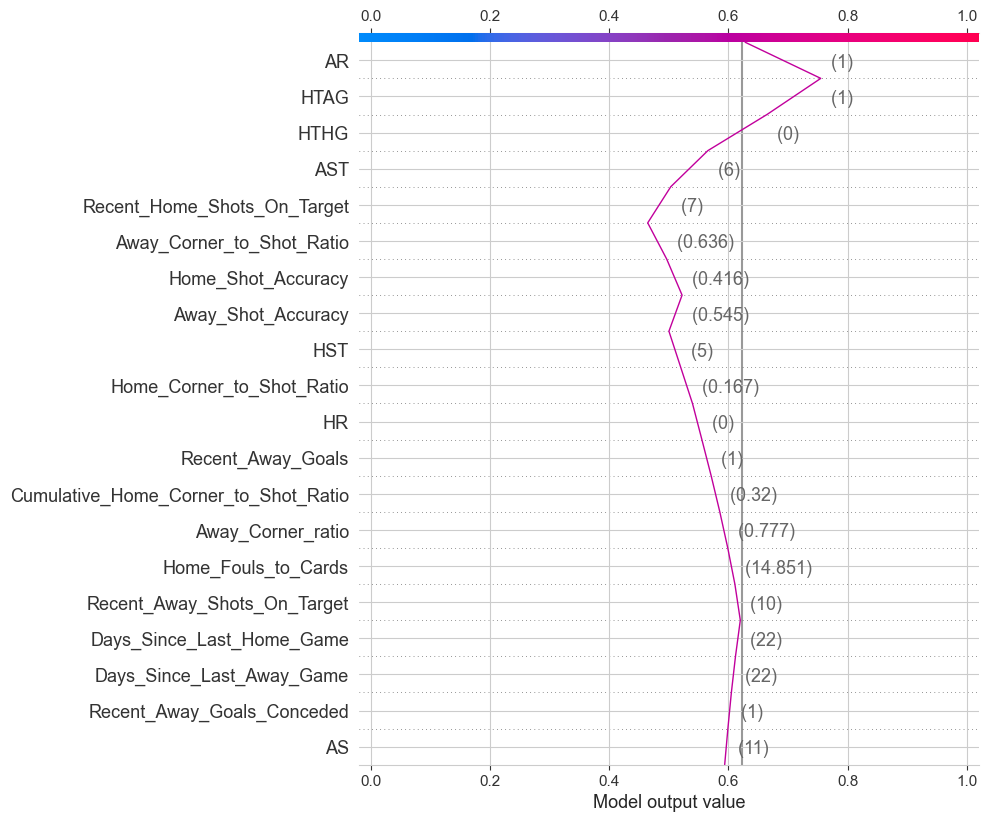

Decision Plot for Misclassified Example 34 in Class 'Away Win'


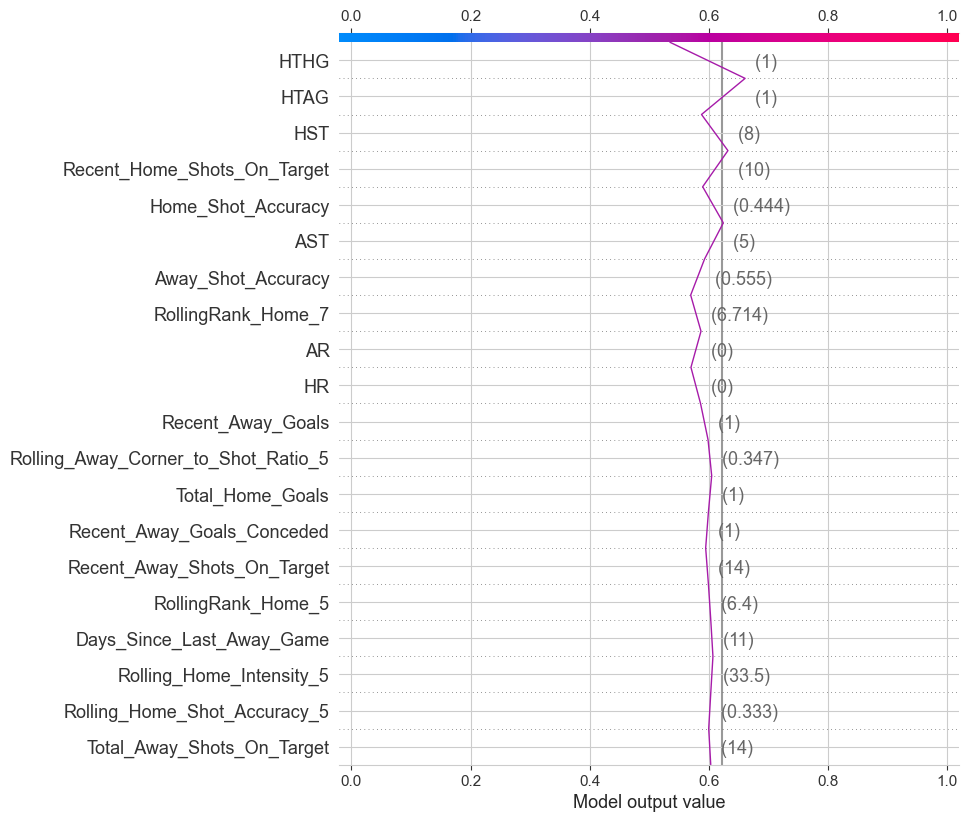

Decision Plot for Misclassified Example 35 in Class 'Away Win'


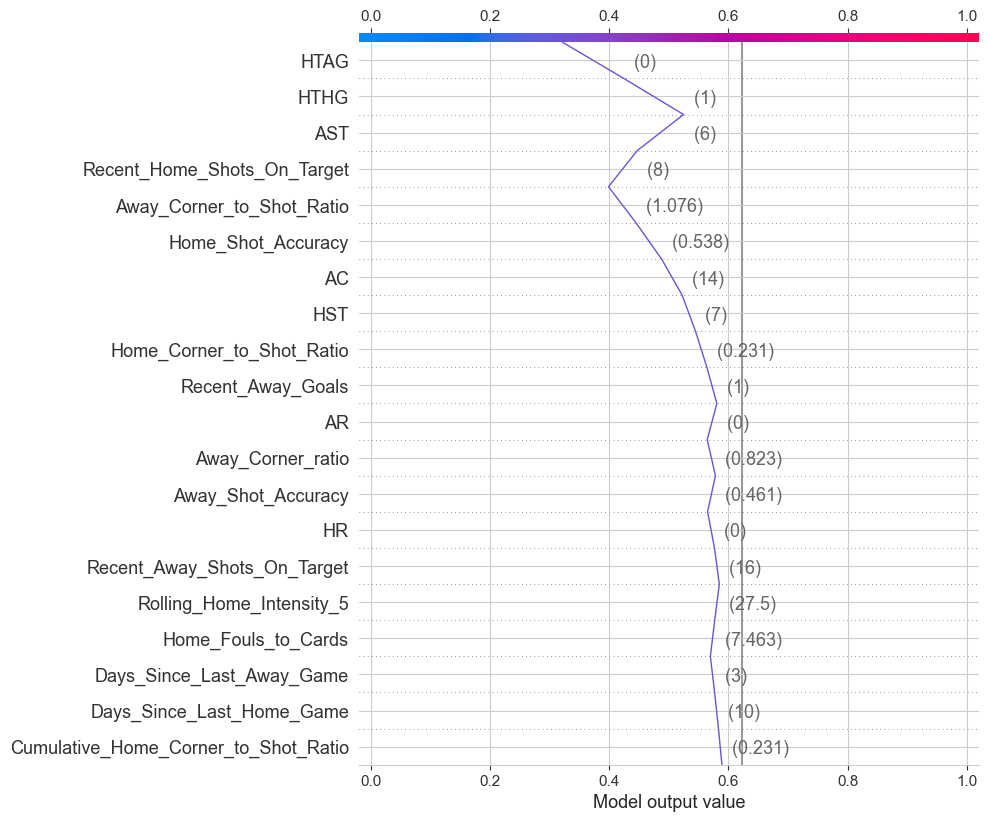

Decision Plot for Misclassified Example 40 in Class 'Away Win'


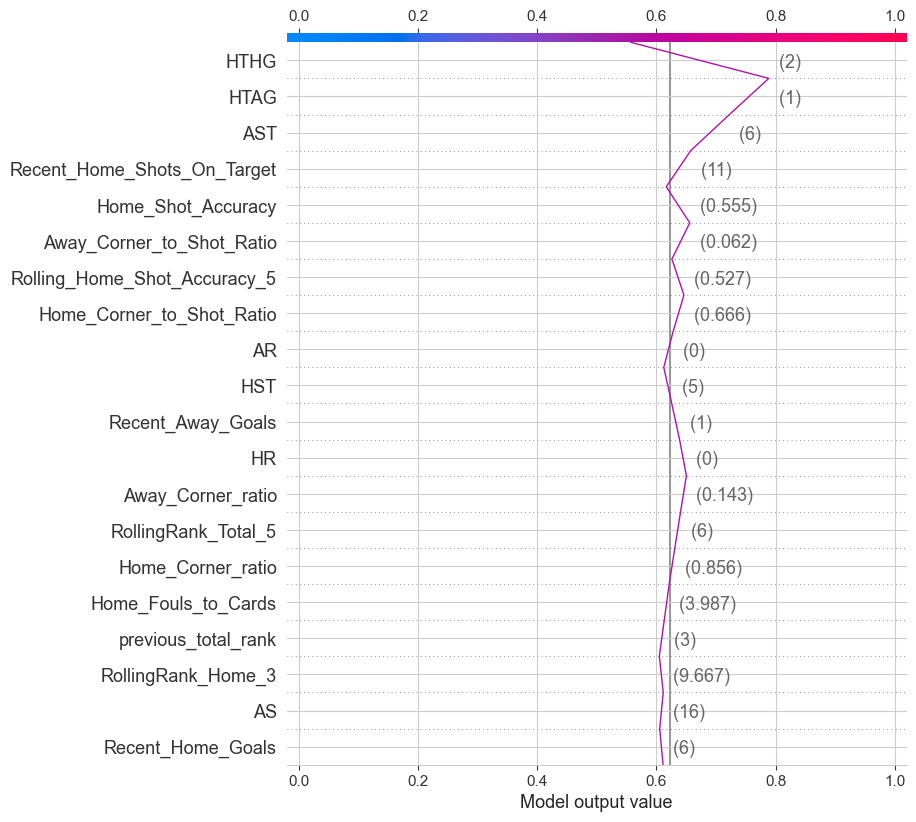

Decision Plot for Misclassified Example 78 in Class 'Away Win'


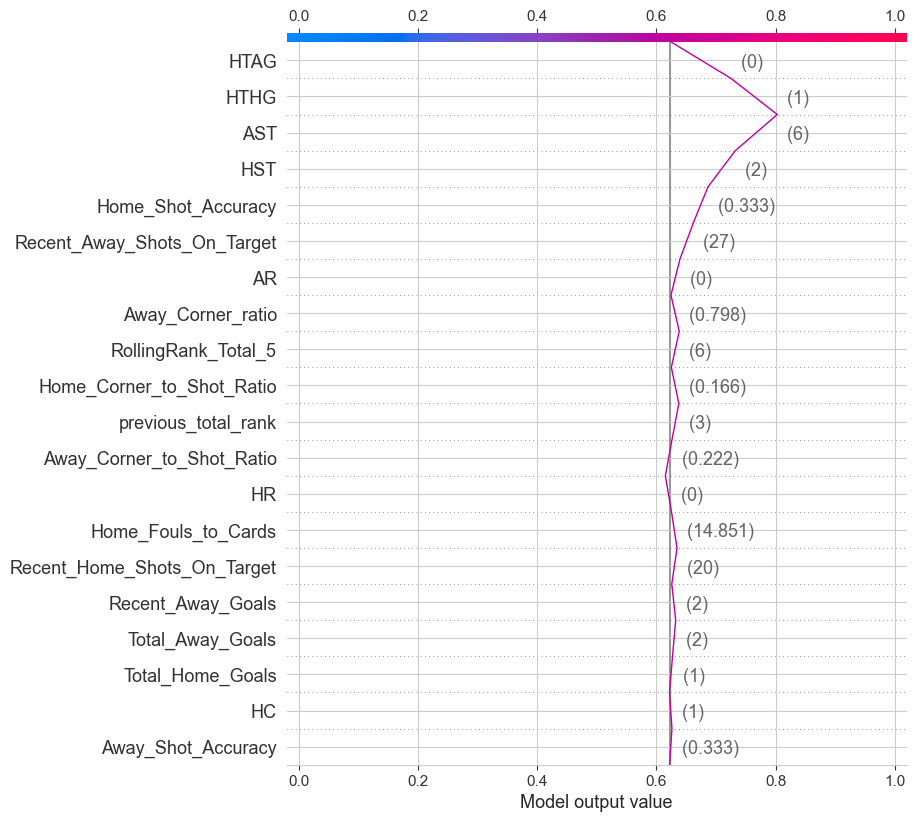

Decision Plot for Misclassified Example 90 in Class 'Away Win'


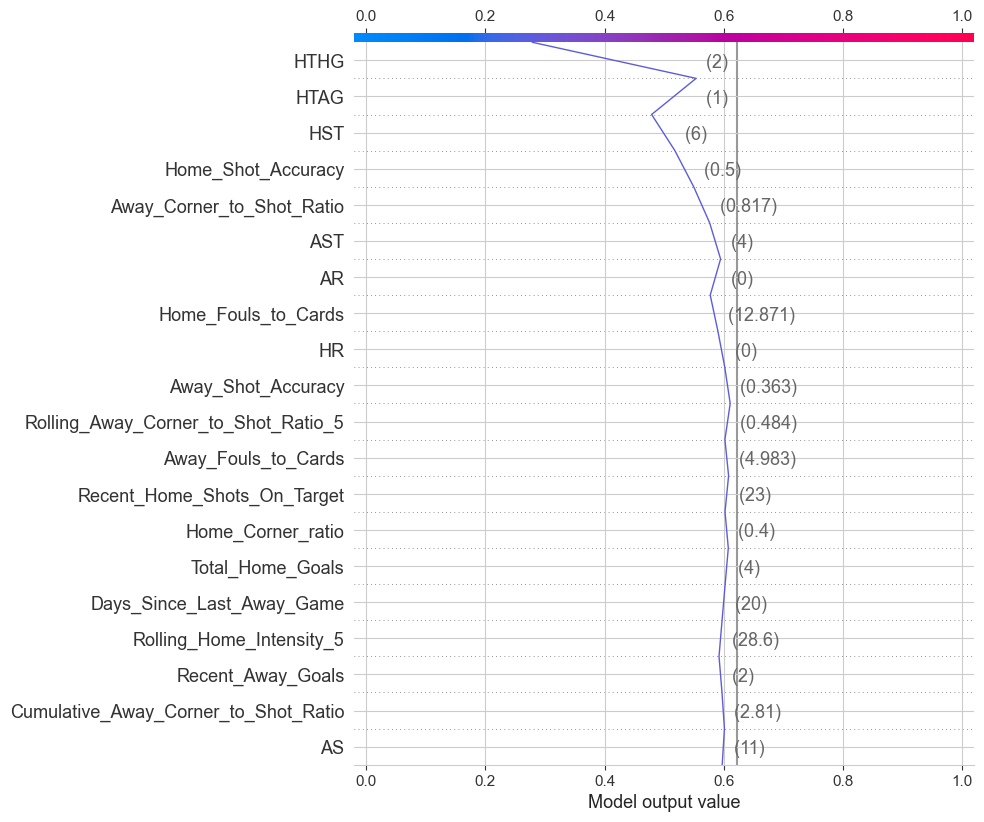

Decision Plot for Misclassified Example 92 in Class 'Away Win'


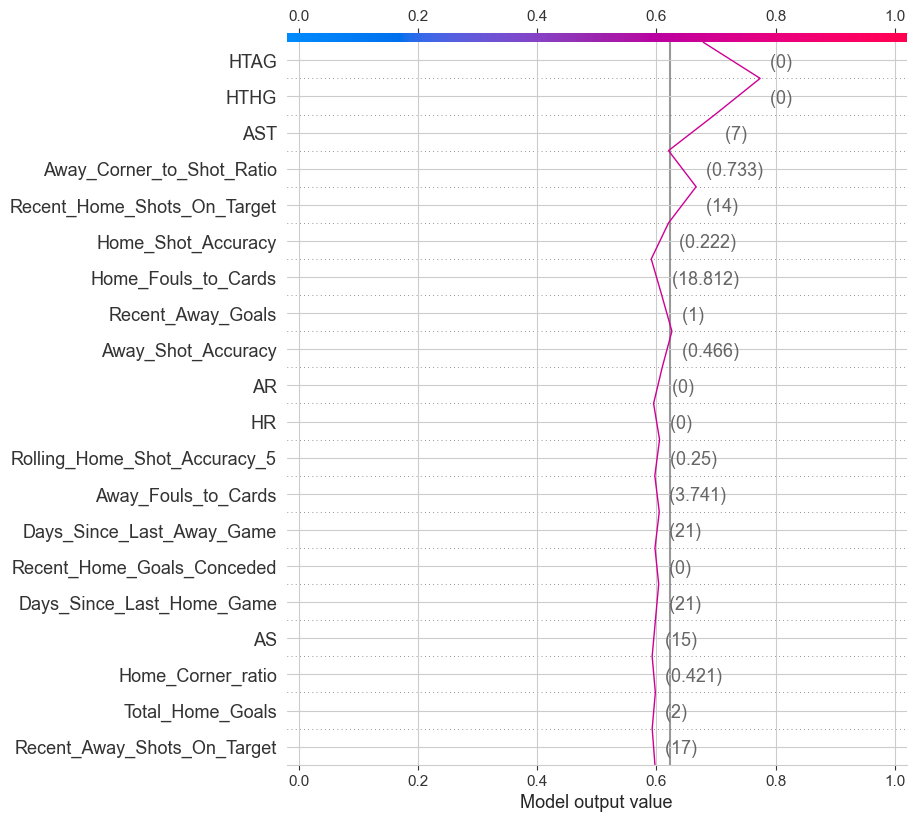

Decision Plot for Misclassified Example 95 in Class 'Away Win'


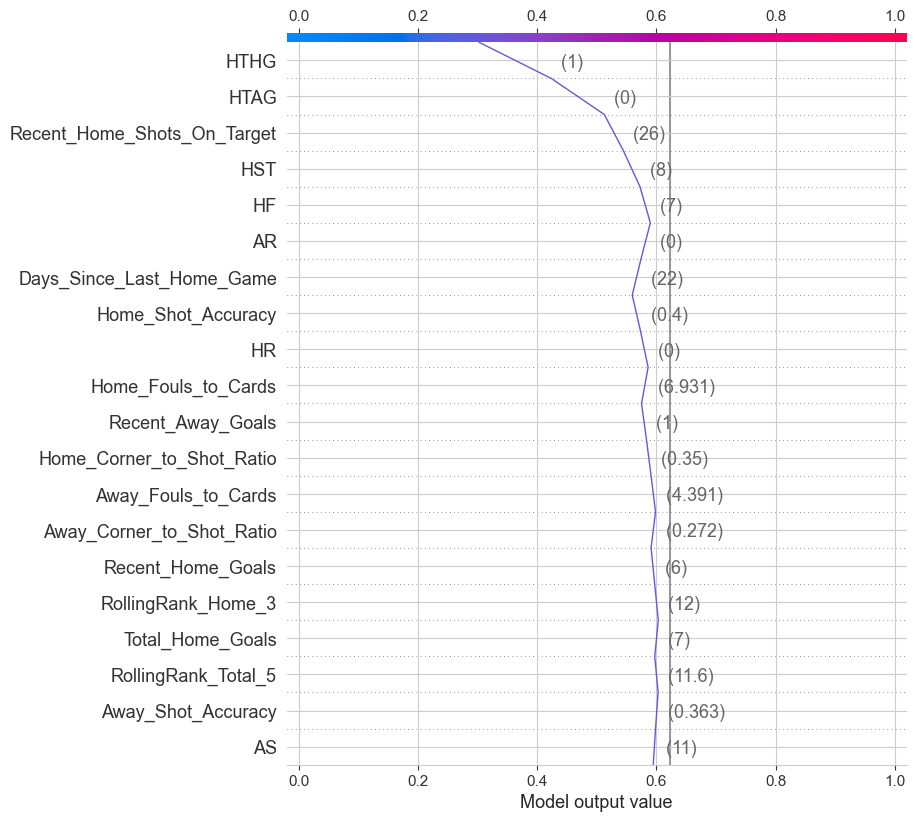

Top 10 misclassified examples for class 'Draw':
Decision Plot for Misclassified Example 8 in Class 'Draw'


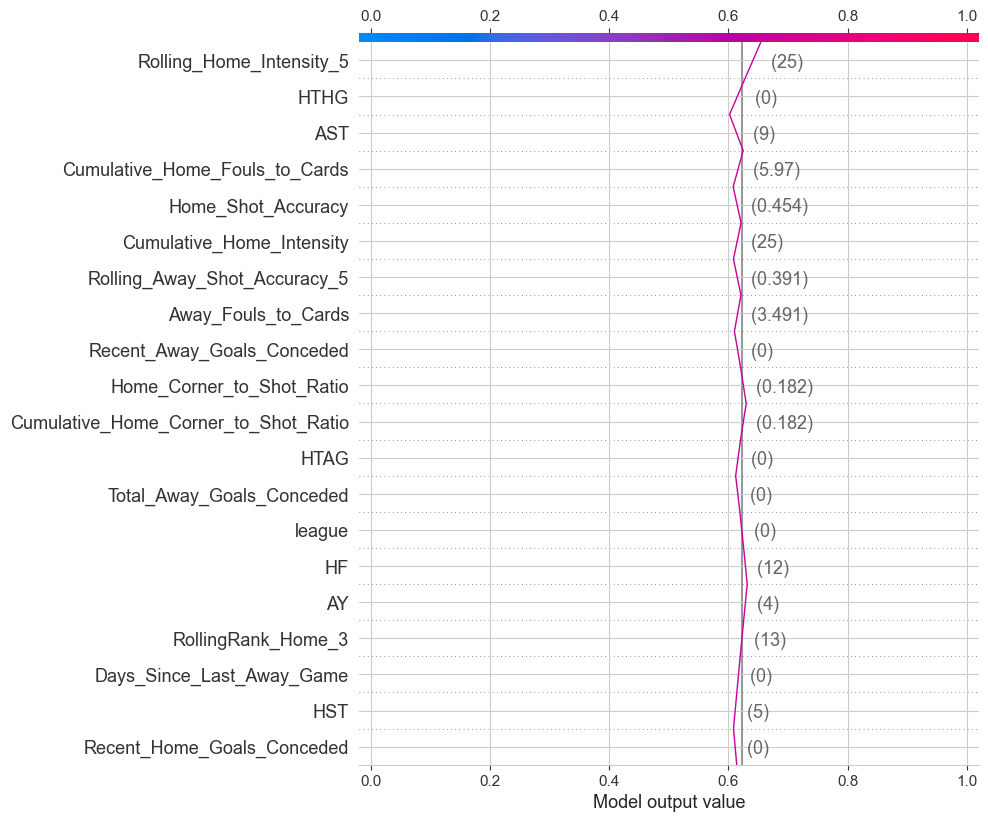

Decision Plot for Misclassified Example 15 in Class 'Draw'


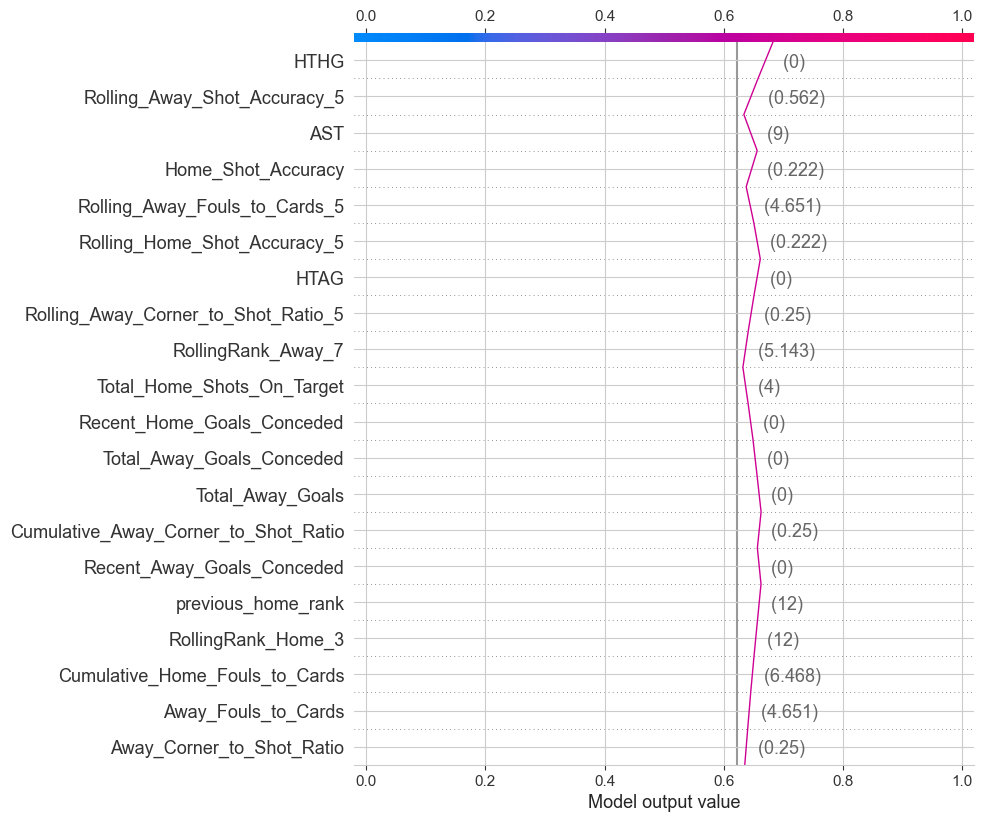

Decision Plot for Misclassified Example 16 in Class 'Draw'


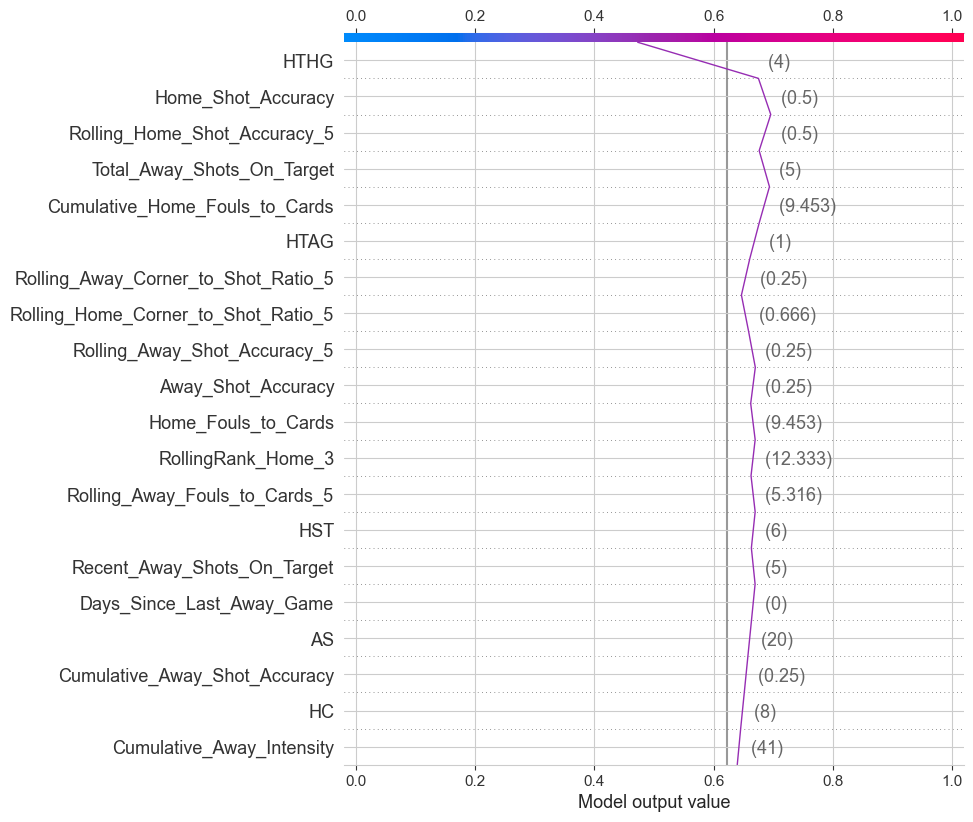

Decision Plot for Misclassified Example 23 in Class 'Draw'


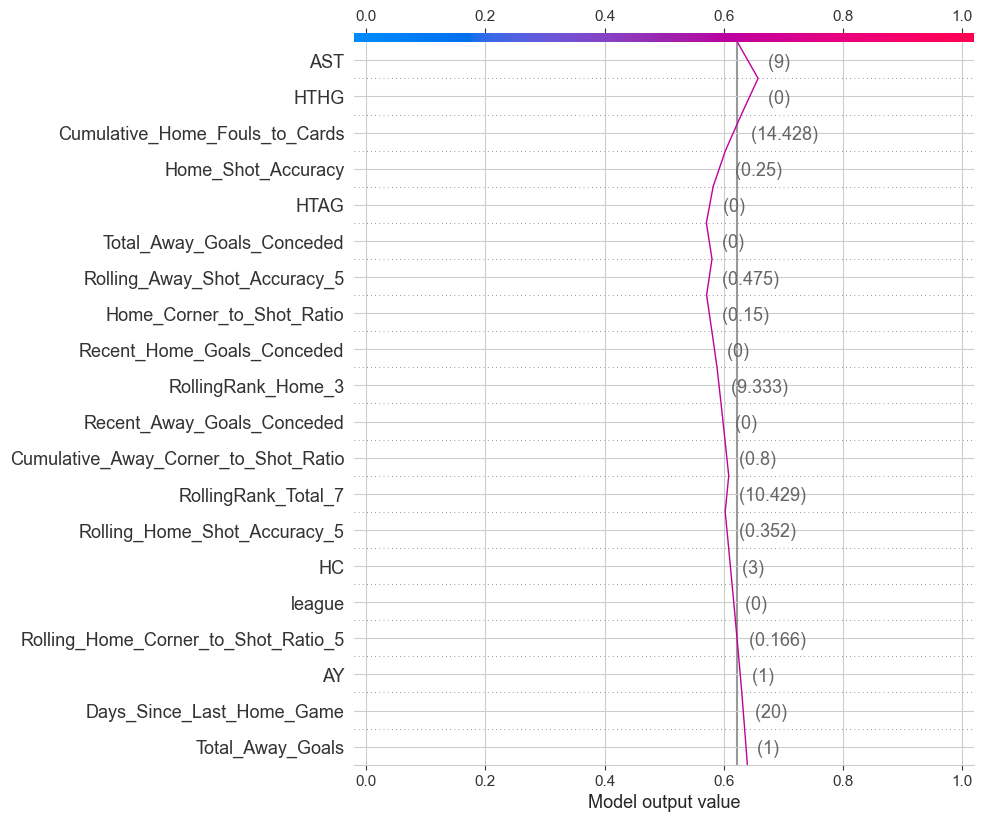

Decision Plot for Misclassified Example 32 in Class 'Draw'


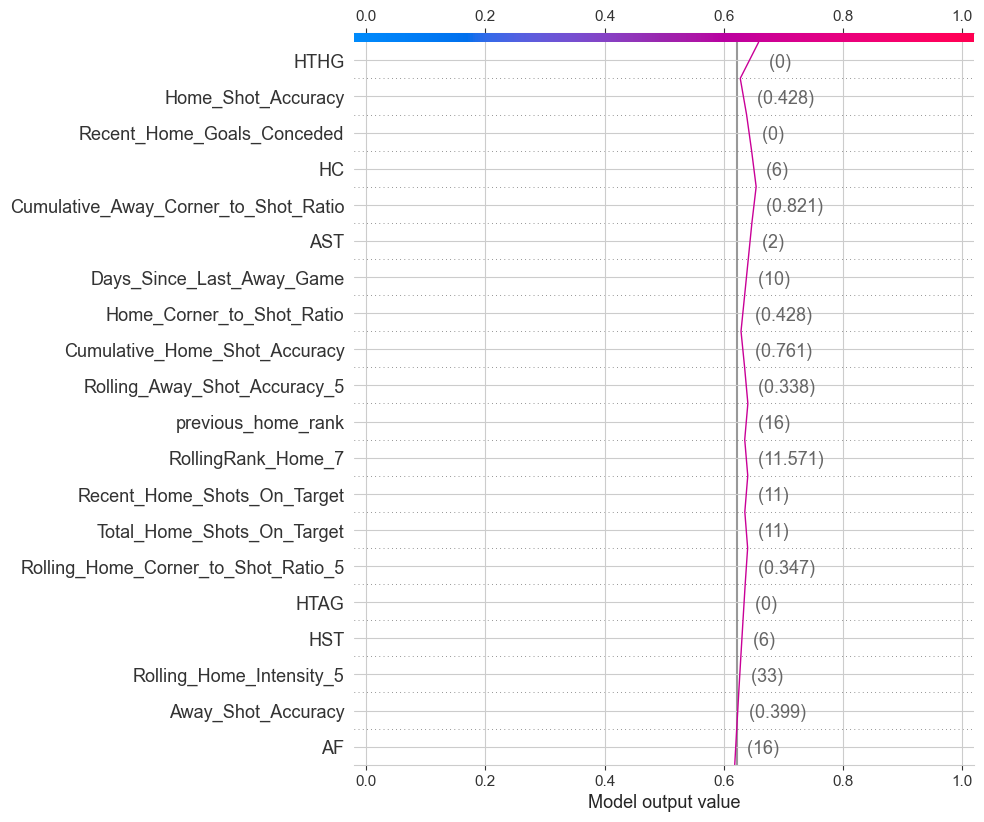

Decision Plot for Misclassified Example 33 in Class 'Draw'


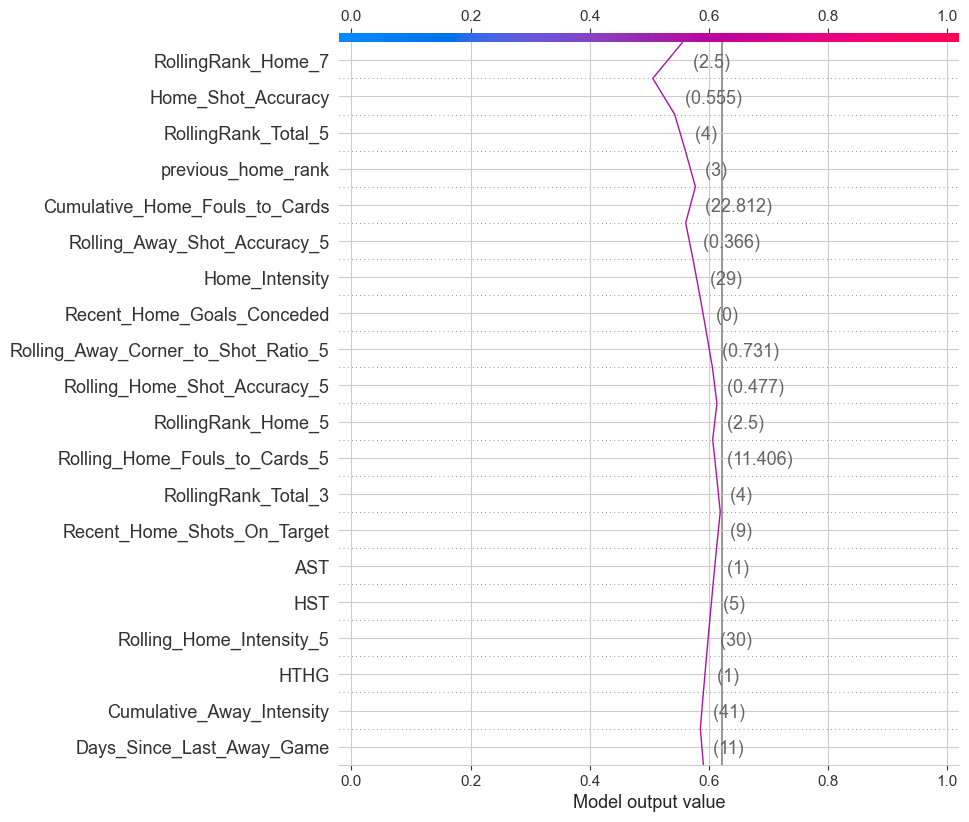

Decision Plot for Misclassified Example 38 in Class 'Draw'


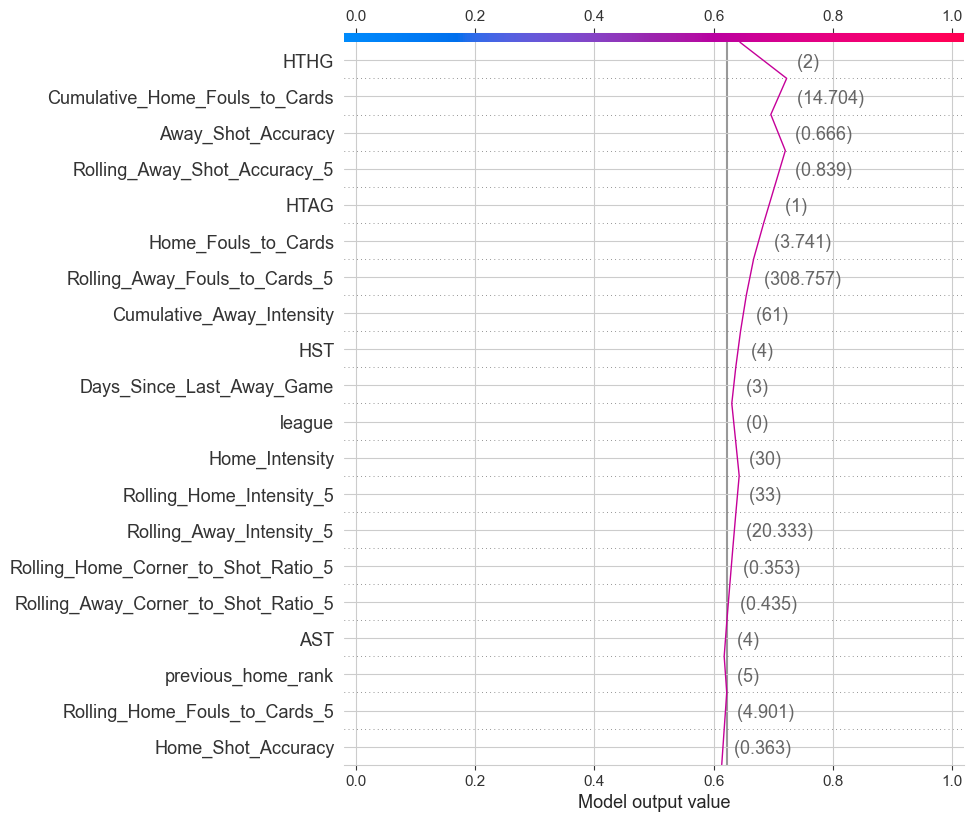

Decision Plot for Misclassified Example 46 in Class 'Draw'


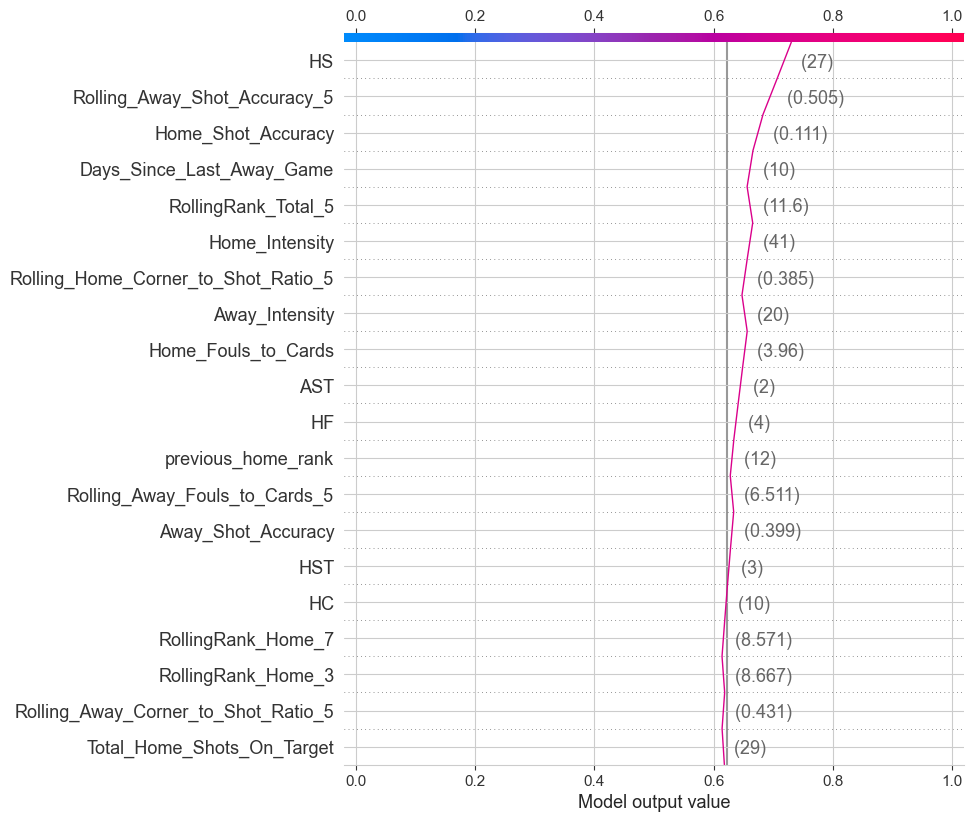

Decision Plot for Misclassified Example 47 in Class 'Draw'


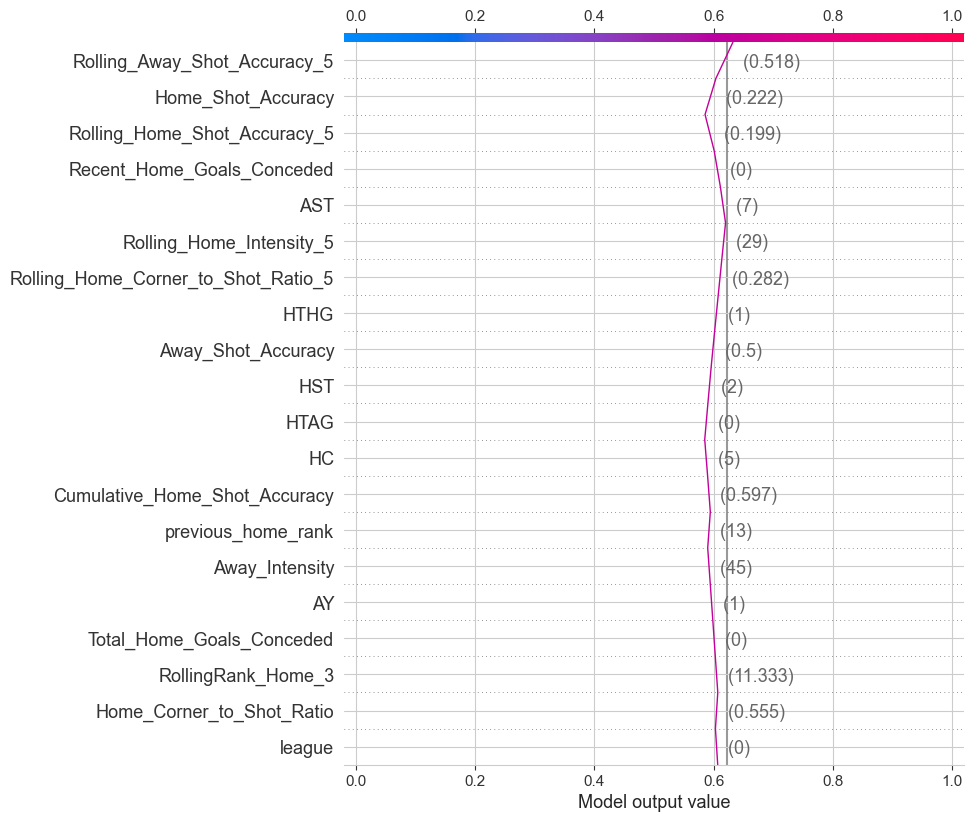

Decision Plot for Misclassified Example 54 in Class 'Draw'


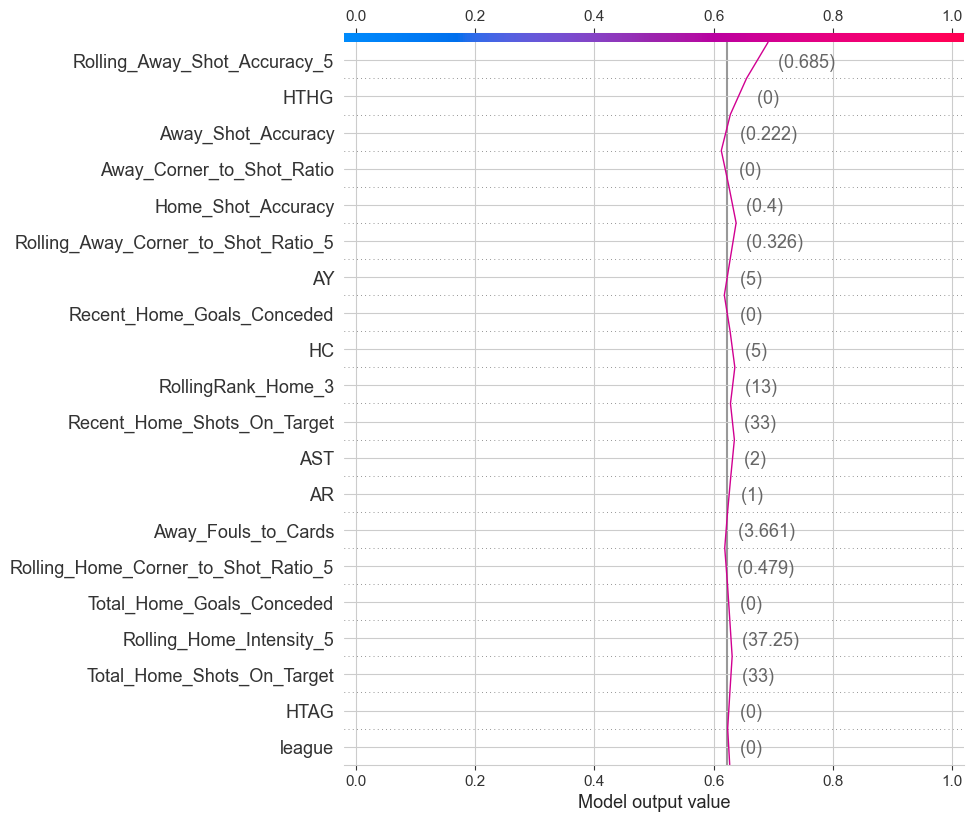

Top 10 misclassified examples for class 'Home win':
Decision Plot for Misclassified Example 10 in Class 'Home win'


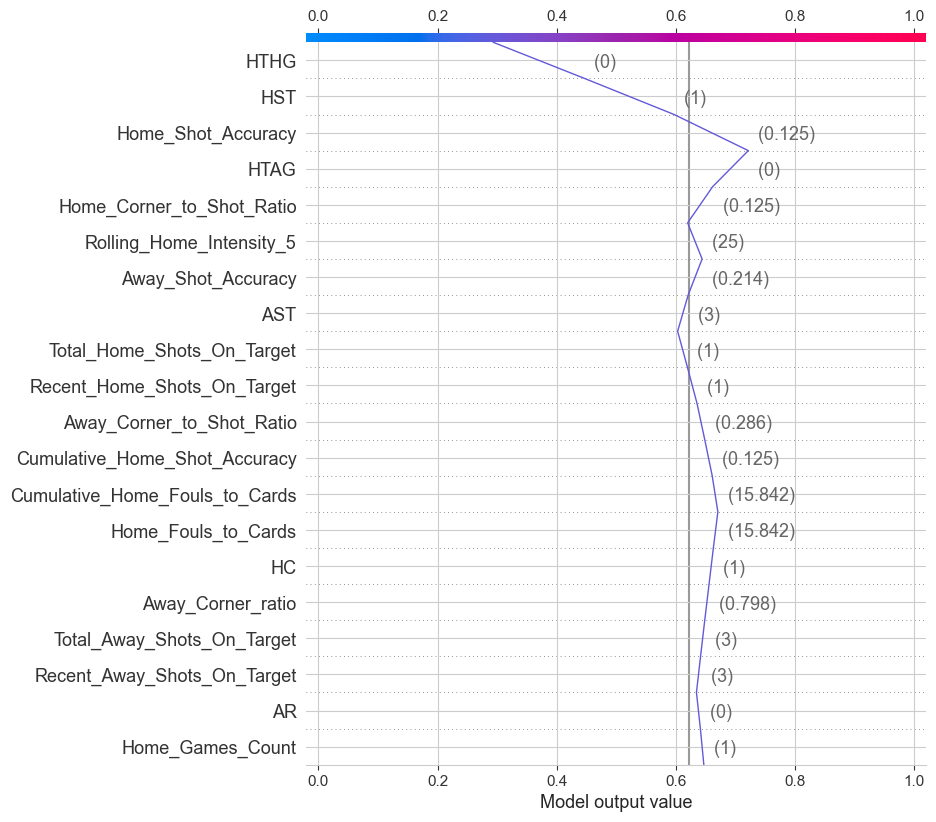

Decision Plot for Misclassified Example 11 in Class 'Home win'


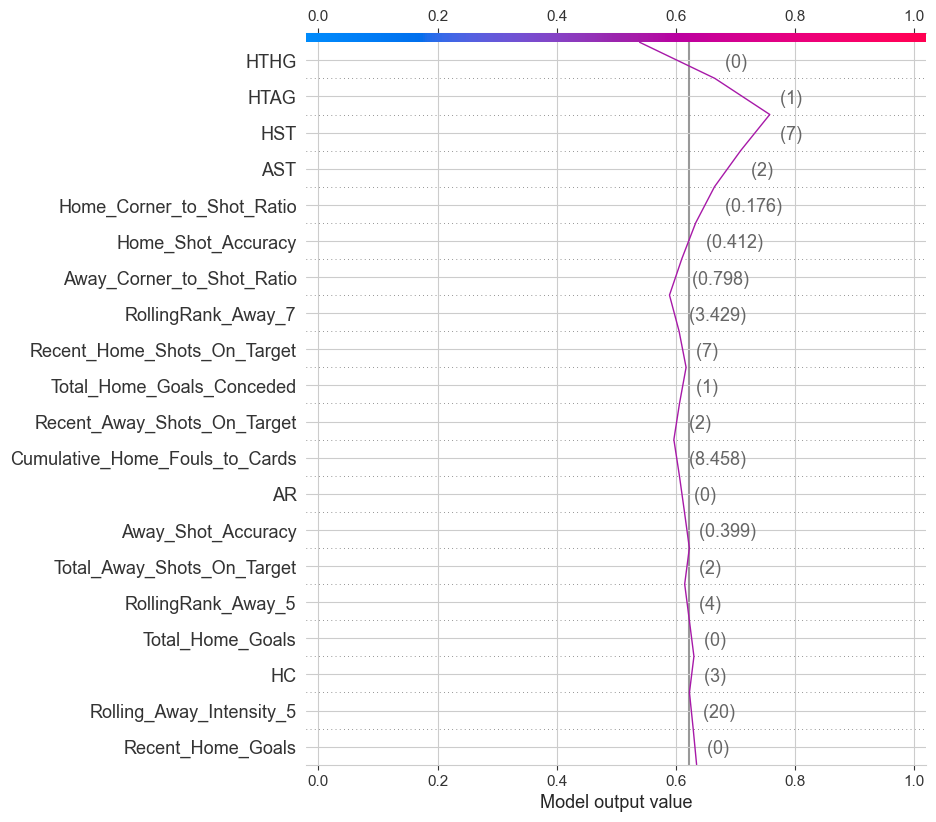

Decision Plot for Misclassified Example 19 in Class 'Home win'


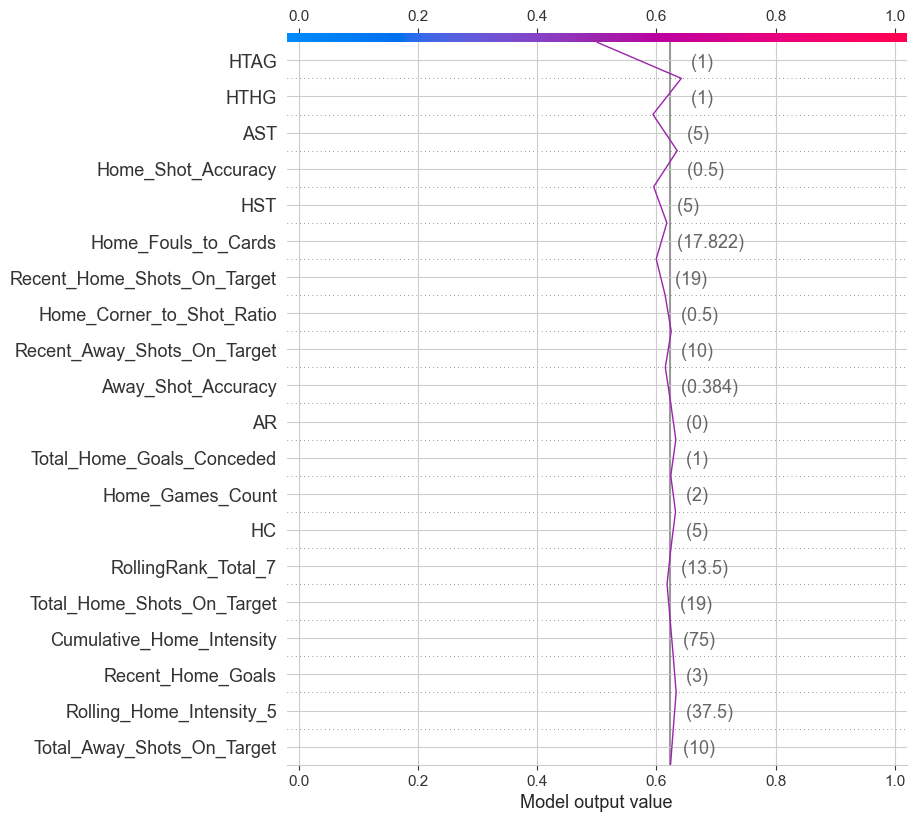

Decision Plot for Misclassified Example 26 in Class 'Home win'


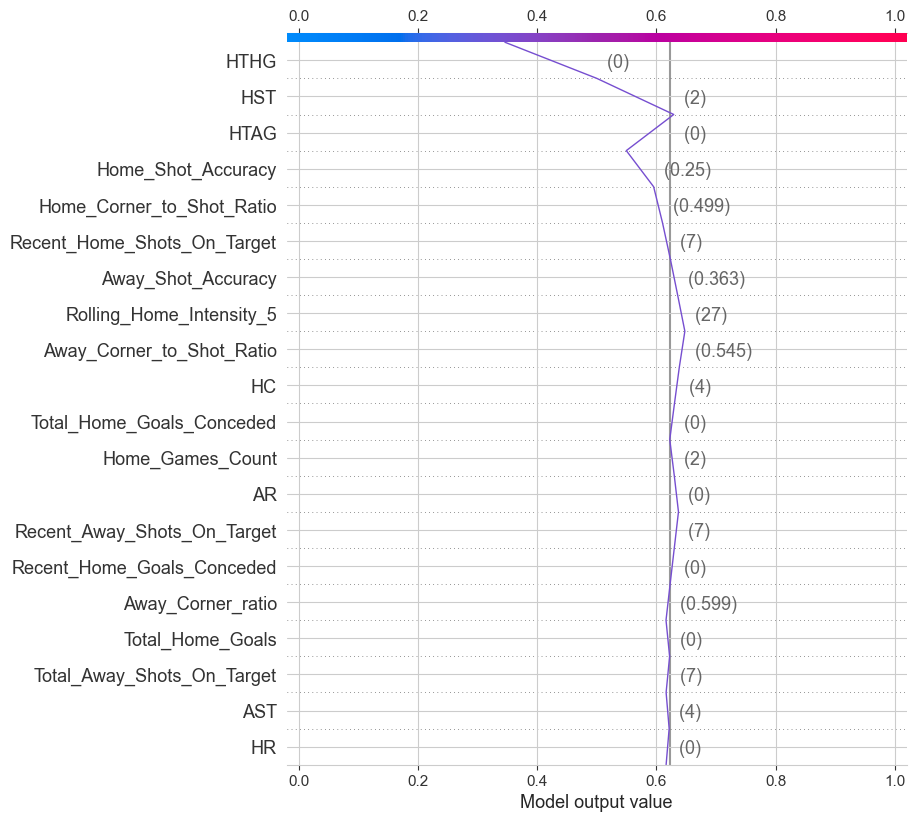

Decision Plot for Misclassified Example 28 in Class 'Home win'


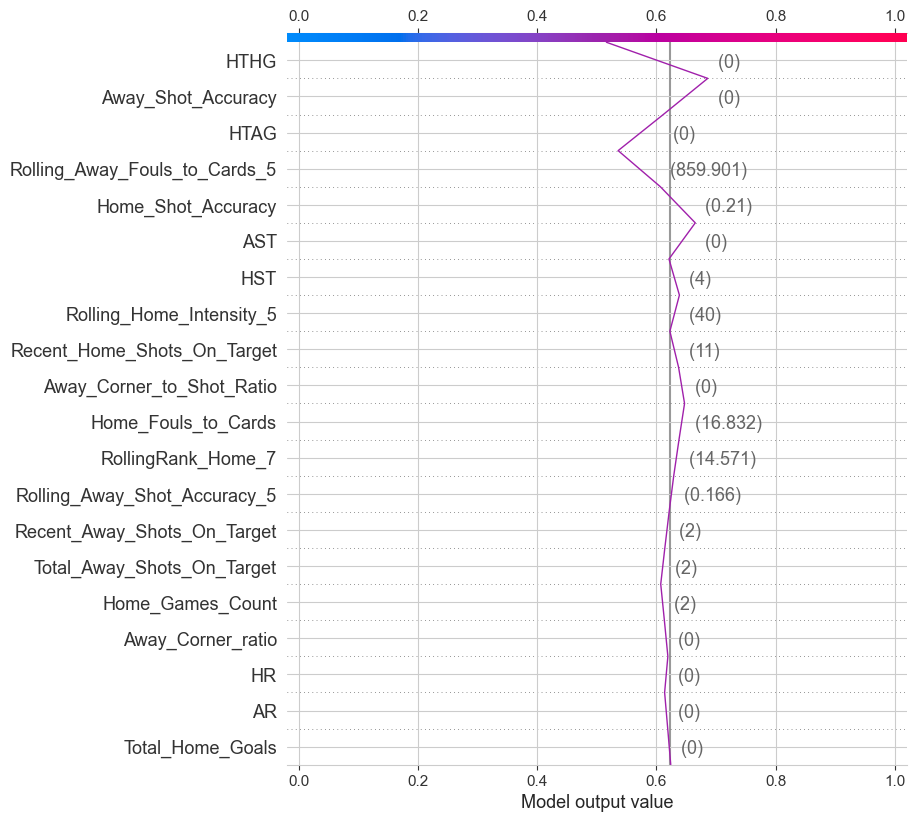

Decision Plot for Misclassified Example 42 in Class 'Home win'


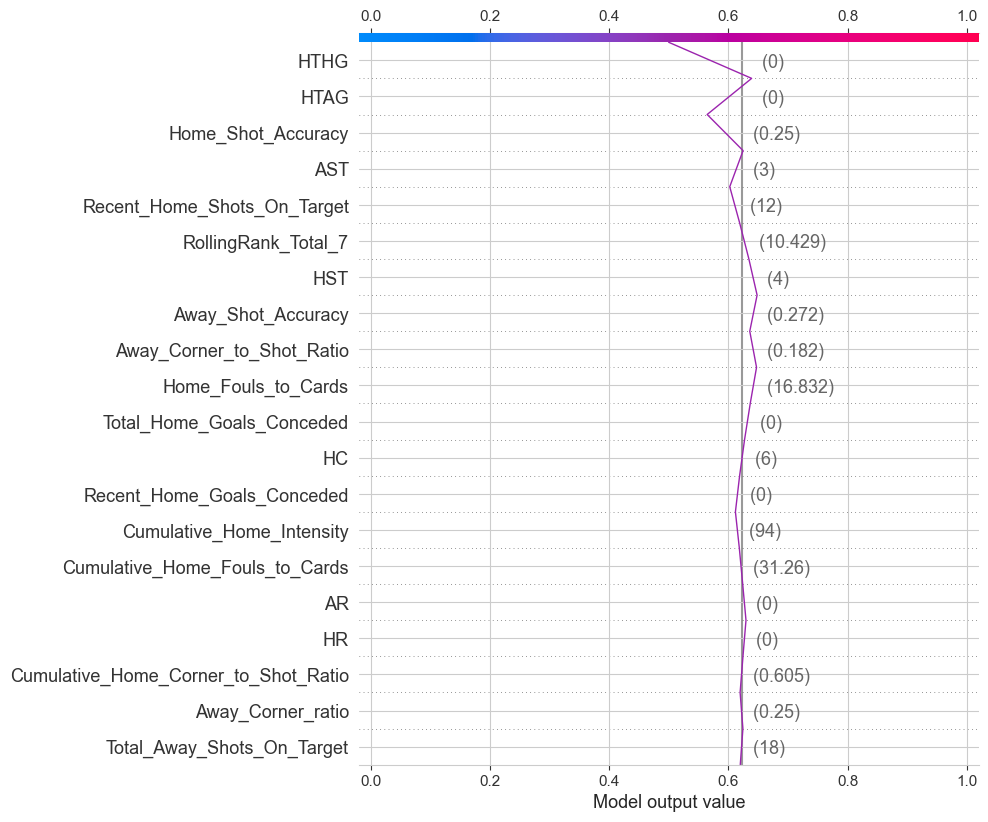

Decision Plot for Misclassified Example 60 in Class 'Home win'


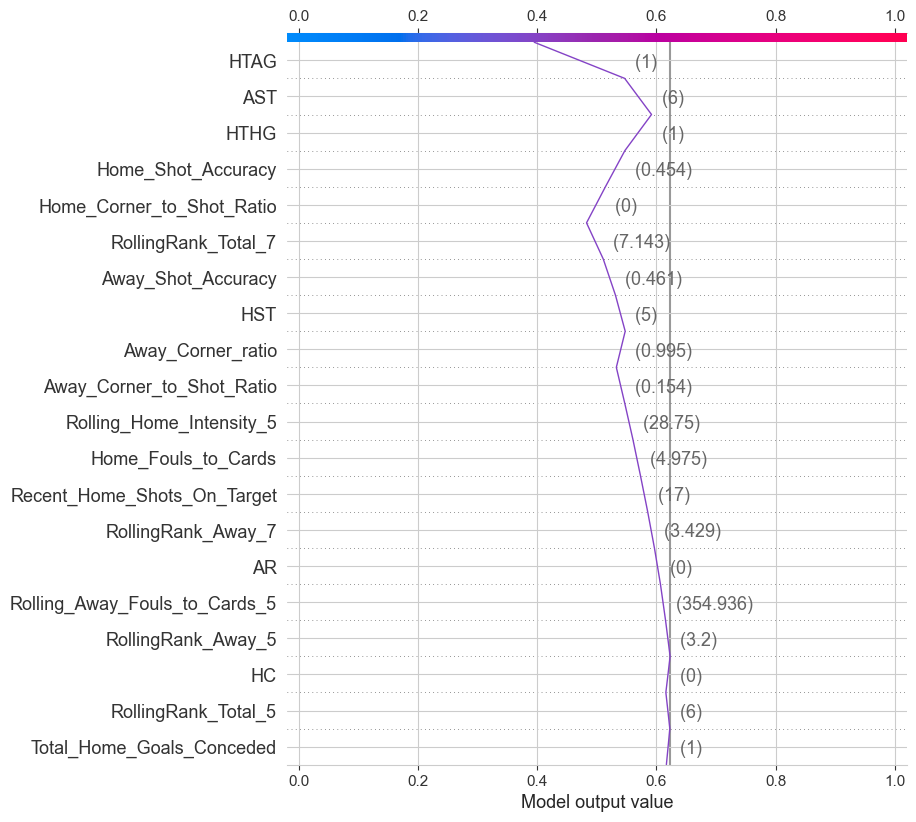

Decision Plot for Misclassified Example 101 in Class 'Home win'


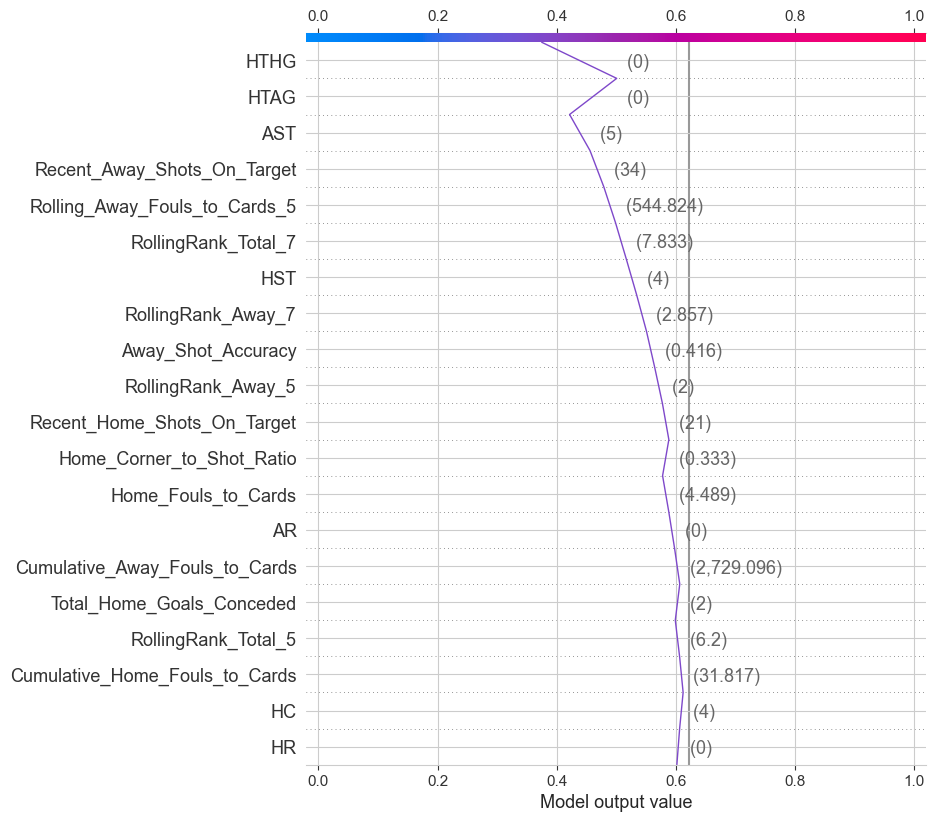

Decision Plot for Misclassified Example 106 in Class 'Home win'


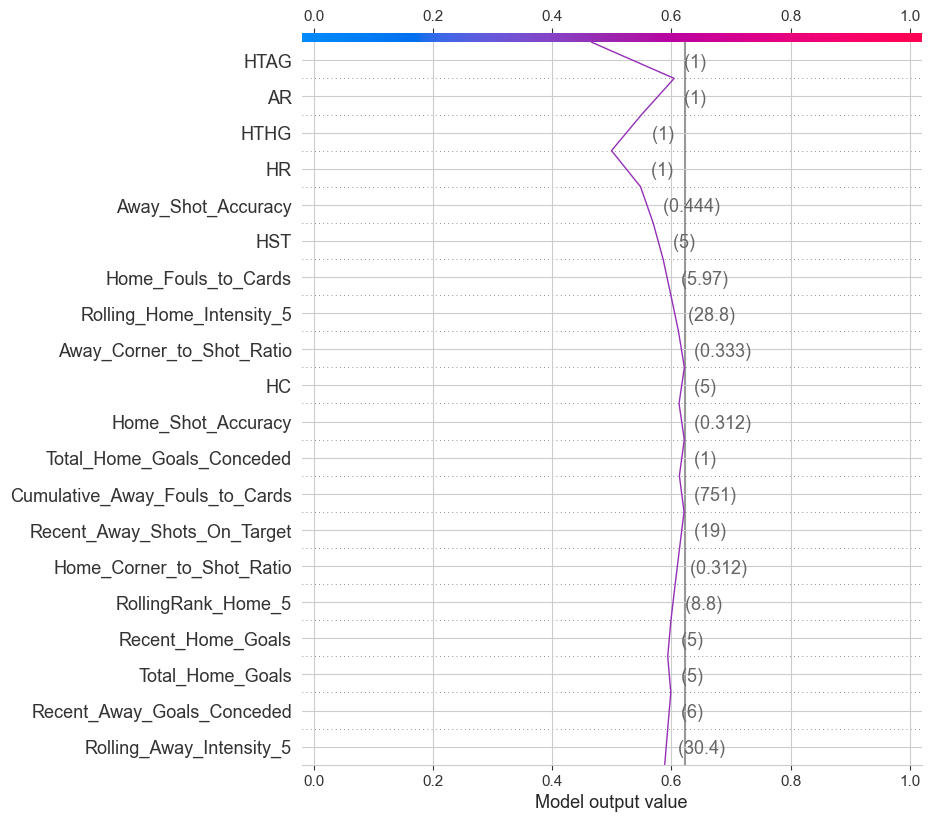

Decision Plot for Misclassified Example 112 in Class 'Home win'


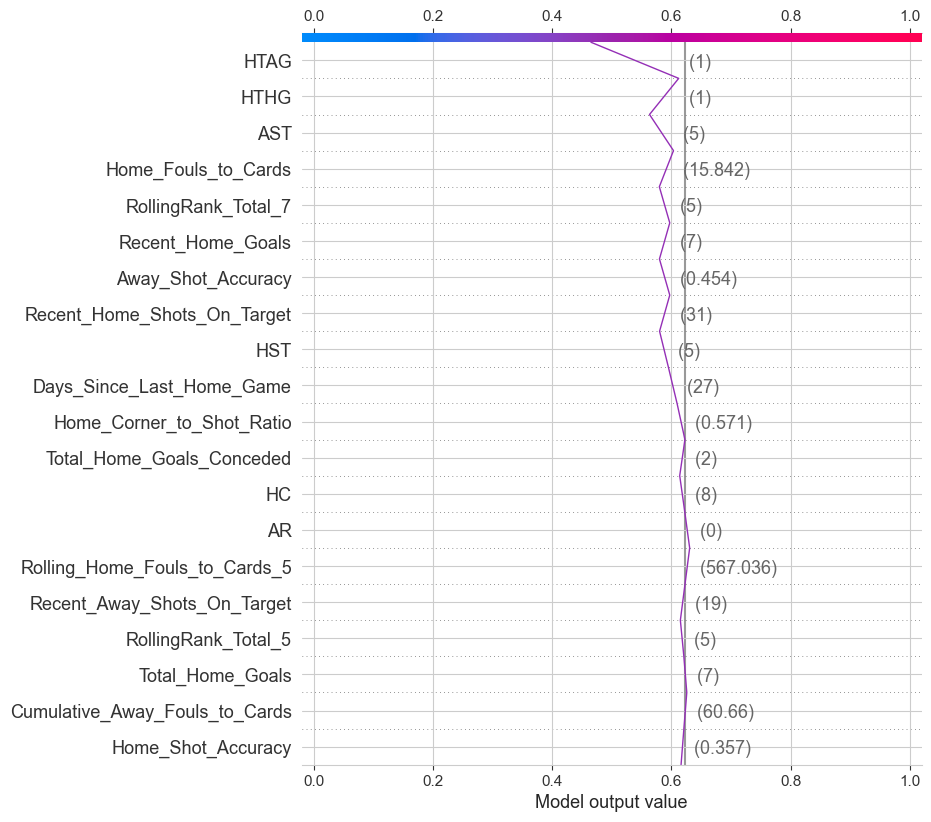

In [131]:
predictions = xgb_best_model.predict(X_test)
errors = predictions != y_test
incorrect_indices = np.where(errors)[0]

#Dictionary to store the indices of misclassified examples for each class
misclassified_by_class = {class_name: [] for class_name in class_names}

#Identify misclassified examples for each class
for idx in incorrect_indices:
    true_class = class_names[y_test[idx]]
    misclassified_by_class[true_class].append(idx)

# For each class, extract the SHAP values and plot the top 10 misclassified examples
for class_idx, class_name in enumerate(class_names):
    if class_name in misclassified_by_class:
        print(f"Top 10 misclassified examples for class '{class_name}':")
        
        # Get indices for top 10 misclassified examples for the current class
        class_indices = misclassified_by_class[class_name]
        if len(class_indices) > 10:
            top_indices = class_indices[:10]
        else:
            top_indices = class_indices
        
        for idx in top_indices:
            print(f"Decision Plot for Misclassified Example {idx} in Class '{class_name}'")

            # shap_values are (num_samples, num_features, num_classes)
            shap_values_instance = shap.Explanation(
                values=shap_values[idx, :, class_idx],
                base_values=shap.TreeExplainer(xgb_best_model).expected_value[class_idx],
                data=X_test.iloc[idx, :],
                feature_names=X_test.columns.tolist()
            )
            
             # Plot decision plot
            shap.decision_plot(
                base_value=shap.TreeExplainer(xgb_best_model).expected_value[class_idx], 
                shap_values=shap_values[idx, :, class_idx],
                features=X_test.iloc[idx, :],
                feature_names=X_test.columns.tolist(),
                link='logit'  # Use 'logit' for classification models if the output is in probability space
            )


In [128]:
# Calculate the mean SHAP values for misclassified examples per class
for class_idx, class_name in enumerate(class_names):
    indices = misclassified_by_class[class_name]
    if len(indices) > 10:
        top_indices = indices[:10]
    else:
        top_indices = indices

    if top_indices:
        # Aggregate the SHAP values
        mean_shap_values = np.mean([shap_values[idx, :, class_idx] for idx in top_indices], axis=0)
        shap_value_df = pd.DataFrame({
            'feature': X_test.columns,
            'shap_value': mean_shap_values
        }).sort_values(by='shap_value', key=abs, ascending=False)

        print(f"Top contributing features for misclassifications in class '{class_name}':")
        print(shap_value_df.head())

Top contributing features for misclassifications in class 'Away Win':
                        feature  shap_value
12                         HTHG   -0.350377
11                         HTAG   -0.140639
4                           AST    0.138927
39  Recent_Home_Shots_On_Target    0.115626
8                            HR   -0.049243
Top contributing features for misclassifications in class 'Draw':
                           feature  shap_value
12                            HTHG   -0.055124
61  Cumulative_Home_Fouls_to_Cards    0.048107
56    Rolling_Away_Shot_Accuracy_5    0.045029
11                            HTAG    0.032973
4                              AST   -0.024556
Top contributing features for misclassifications in class 'Home win':
                        feature  shap_value
12                         HTHG   -0.284587
10                          HST   -0.137953
11                         HTAG   -0.125017
45           Home_Shot_Accuracy   -0.088689
39  Recent_Home_Shots_On_Tar

#### Feature Selection
- lets use RFECV to select the relevant features

In [149]:
rfecv = RFECV(estimator=xgb_best_model, step=1, min_features_to_select=20, cv=StratifiedKFold(5), scoring='precision_macro')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='mlogloss',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_ty...
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None,
                              objective='multi:softprob', ...),
      min_features_to_select=20, scoring='precision_macro')

In [150]:
selected_features = X_train.columns[rfecv.support_]

In [151]:
selected_features

Index(['AR', 'AST', 'HC', 'HR', 'HST', 'HTAG', 'HTHG', 'RollingRank_Total_3',
       'RollingRank_Total_5', 'RollingRank_Total_7', 'Total_Home_Goals',
       'Recent_Home_Goals', 'Recent_Away_Goals', 'Recent_Home_Shots_On_Target',
       'Recent_Away_Shots_On_Target', 'Home_Shot_Accuracy',
       'Away_Shot_Accuracy', 'Home_Corner_to_Shot_Ratio',
       'Away_Corner_to_Shot_Ratio', 'Home_Fouls_to_Cards',
       'Rolling_Away_Shot_Accuracy_5', 'Cumulative_Away_Intensity'],
      dtype='object')

In [152]:
X_train_selected= X_train[selected_features]
X_test_selected = X_test[selected_features]

Model Performance on Test Set:
Precision: 0.6312686930369348
Recall: 0.6304731235129512
F1 Score: 0.629028449972684
ROC AUC Score (macro): 0.835829064659736

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71       516
           1       0.43      0.35      0.38       421
           2       0.77      0.82      0.79       888

    accuracy                           0.68      1825
   macro avg       0.63      0.63      0.63      1825
weighted avg       0.67      0.68      0.68      1825

Cross-validated Precision scores: [0.62572701 0.61337046 0.62054864 0.63251148 0.6047389 ]
Mean Cross-validated Precision score: 0.6193792993586309


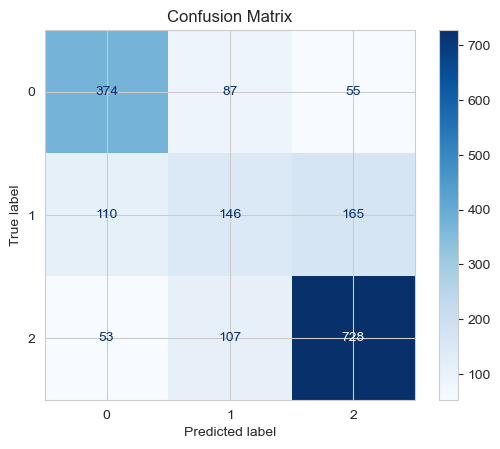

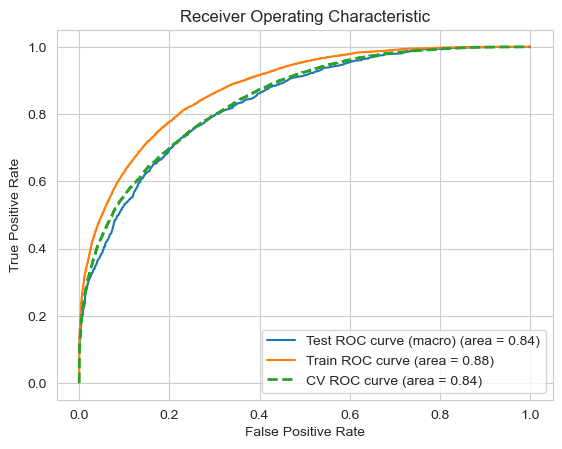

In [153]:
xgb_results_tuned = evaluate_model(xgb_best_model, X_train_selected, y_train, X_test_selected, y_test, cv=5)

- the refined model gives better precision

### Model limitations and further explorations

- High importance doesn't imply causality but rather a strong association used by the model for predictions
- There are lot of variables that the model doesnt account for, example players performance, extras, team positions, managers, coaches etc.
- the model here generally doest perform well for draws, we may need to explore on why that is
- The results here was based on random subset of data, but we also need to account for anomalies and outlier events that may be occuring.A better curated test on these instances will provides a better genralisation.for example - no one knew that leicester would win EPL in 2014 
- Beyond individual feature importance, exploring interaction effects between features can provide deeper insights, which can be explored with PDP's,ALE etc.
- We can perform senstivity analysis and utilise different shap plots to get deeper insights for incorrectly identified instances,we can further investigate feature an repeat the process.

### Making Predictions

In [176]:
X_train_full = train_data.drop(columns=['FTR', 'season', 'HomeTeam', 'AwayTeam','Date'])
X_test_full = test_data.drop(columns=['FTR', 'season', 'HomeTeam', 'AwayTeam','Date'])
y_train_full = train_data['FTR']
y_train_full = le.fit_transform(y_train_full)
X_train_full= X_train_full[selected_features]
X_test_full = X_test_full[selected_features]

In [177]:
xgb_best_model.fit(X_train_full,y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [178]:
y_pred = xgb_best_model.predict(X_test_full)

In [179]:
y_pred

array([2, 2, 2, ..., 0, 2, 2])

In [180]:
y_pred = le.inverse_transform(y_pred)

In [181]:
y_pred

array(['H', 'H', 'H', ..., 'A', 'H', 'H'], dtype=object)

In [182]:
y_pred = pd.DataFrame(y_pred, columns=['FTR'])

In [188]:
test_data['FTR'] = y_pred['FTR']

In [189]:
test_data.to_csv('test_data_predicted.csv',index=False)